# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [60]:
%%pycodestyle


class MyKmeans:

    def __init__(self, k=2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        ## Your Code Here
        # ...
        if self.init == 'random':
            indeces = np.arange(X.shape[0])
            np.random.shuffle(indeces)
            indeces = indeces[:self.k]
            self.centroids = X[indeces]
        elif self.init == 'k-means':
            i0 = np.random.randint(0, X.shape[0])
            centroids = X[i0].reshape((1,-1))
            for i in range(self.k-1):
                dists_sqr = cdist(X, centroids, self.metric)**2
                min_dists_sqr = np.min(dists_sqr, axis=1)
                dists_cumsum = min_dists_sqr.cumsum()
                r = np.random.random() * dists_cumsum[-1]
                for j in range(dists_cumsum.size):
                    if r < dists_cumsum[j]:
                        centroids = np.concatenate((centroids, 
                                                    X[j].reshape((1, -1))), 
                                                   axis=0)
                        break
            self.centroids = centroids
        else:
            print('incorrect init')
            return

        dists = cdist(X, self.centroids, self.metric)
        self.labels = np.argmin(dists, axis=1)
        old_centroids = self.centroids.copy()
        for i in range(self.max_iter):
            for j in range(self.k):
                C = X[self.labels == j]
                C = self.get_batch(C)
                if C.shape[0] != 0:
                    self.centroids[j] = 1./C.shape[0] * C.sum(axis=0)
            dists = cdist(X, self.centroids, self.metric)
            self.labels = np.argmin(dists, axis=1)
            if (self.centroids-old_centroids).all() < 0.0001:
                break
            old_centroids = self.centroids.copy()
        return self

    def get_batch(self, X):
        return X

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        dists = cdist(X, self.centroids, self.metric)
        return np.argmin(dists, axis=1)


class MiniBatchKMeans(MyKmeans):
    def get_batch(self, X):
        batch_size = int(0.2*X.shape[0])
        indeces = random.sample(range(X.shape[0]), batch_size)
        return X[indeces]

35:9: E266 too many leading '#' for block comment
44:41: E231 missing whitespace after ','
52:63: W291 trailing whitespace
53:76: W291 trailing whitespace


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

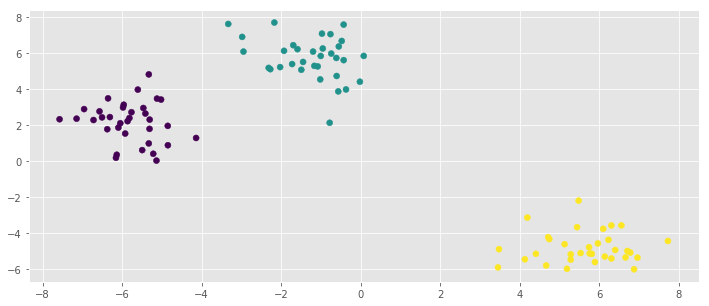

In [6]:
plt.rcParams['figure.figsize'] = (12,5)
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

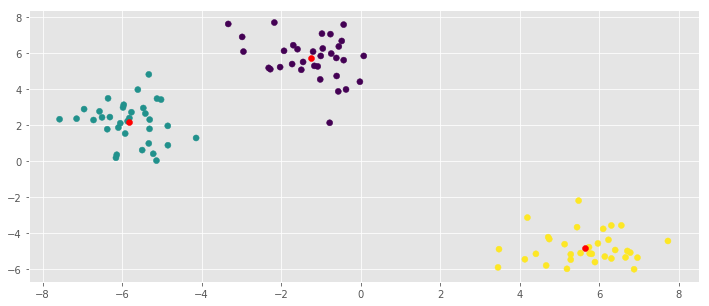

In [7]:
## Работоспособность MyKmeans
mykmeans = MyKmeans(k=3)
mykmeans.fit(X)
c = mykmeans.centroids
pred_y = mykmeans.predict(X)
plt.scatter(X[:,0], X[:, 1], c=pred_y)
plt.scatter(c[:,0], c[:, 1], c='red')

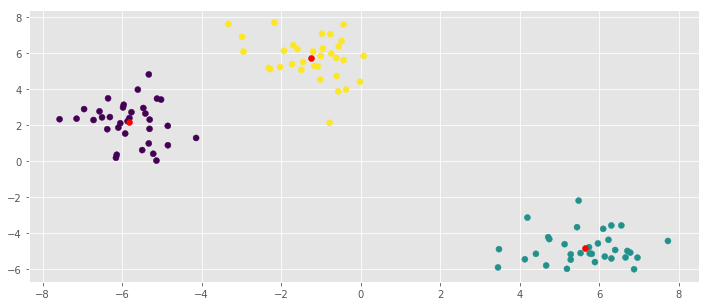

In [8]:
## Работоспособность MyKmeans++
mykmeans = MyKmeans(k=3, init='k-means')
mykmeans.fit(X)
c = mykmeans.centroids
pred_y = mykmeans.predict(X)
plt.scatter(X[:,0], X[:, 1], c=pred_y)
plt.scatter(c[:,0], c[:, 1], c='red')

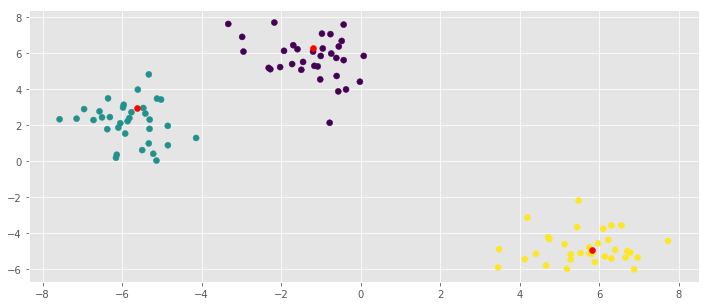

In [9]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
mykmeans = MiniBatchKMeans(k=3)
mykmeans.fit(X)
c = mykmeans.centroids
pred_y = mykmeans.predict(X)
plt.scatter(X[:,0], X[:, 1], c=pred_y)
plt.scatter(c[:,0], c[:, 1], c='red')

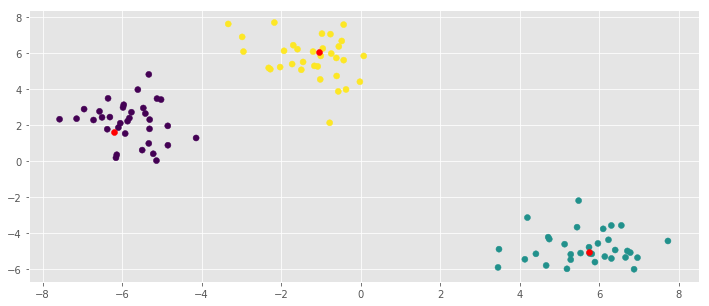

In [10]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
mykmeans = MiniBatchKMeans(k=3, init='k-means')
mykmeans.fit(X)
c = mykmeans.centroids
pred_y = mykmeans.predict(X)
plt.scatter(X[:,0], X[:, 1], c=pred_y)
plt.scatter(c[:,0], c[:, 1], c='red')

In [13]:
from sklearn.cluster import KMeans
import time

In [32]:
n_times = 10
n_tries = 100
x = np.linspace(100, 10000, n_times)
def get_times(kmeans, n_times=n_times, n_tries=n_tries, x=x):
    times = np.zeros(n_times)
    for i, n_samples in enumerate(x):
        X, y = make_blobs(n_samples=int(n_samples), n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
        for j in range(n_tries):
            t1 = time.time() * 1000
            kmeans.fit(X)
            t2 = time.time() * 1000
            times[i] += t2-t1
    return times / n_tries

In [47]:
## Время выполнения алгоритма Kmeans из sklearn
kmeans = KMeans(n_clusters=3)
%time kmeans.fit(X)
kmeans_times = get_times(kmeans, n_tries=10)

CPU times: user 112 ms, sys: 124 ms, total: 236 ms
Wall time: 87.9 ms


In [34]:
## Время выполнения алгоритма MyKmeans
mykmeans = MyKmeans(k=3)
%time mykmeans.fit(X)
mykmeans_times = get_times(mykmeans)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.81 ms


In [35]:
## Время выполнения алгоритма MyKmeans++
mykmeans = MyKmeans(k=3, init='k-means')
%time mykmeans.fit(X)
mykmeanspp_times = get_times(mykmeans)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 12.3 ms


In [39]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
mykmeans = MiniBatchKMeans(k=3, max_iter=300)
%time mykmeans.fit(X)
mykmeansMB_times = get_times(mykmeans, n_tries=10)

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.28 s


In [40]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
mykmeans = MiniBatchKMeans(k=3, init='k-means', max_iter=300)
%time mykmeans.fit(X)
mykmeansMBpp_times = get_times(mykmeans, n_tries=10)

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.26 s


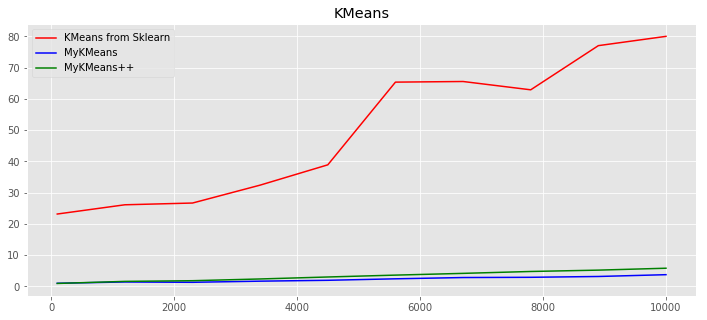

In [49]:
plt.plot(x, kmeans_times, c='r', label='KMeans from Sklearn')
plt.plot(x, mykmeans_times, c='b', label='MyKMeans')
plt.plot(x, mykmeanspp_times, c='g', label='MyKMeans++')
plt.legend()
plt.title('KMeans')
plt.show()

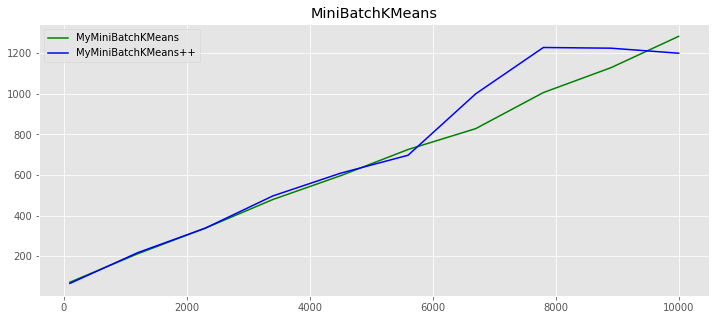

In [50]:
plt.plot(x, mykmeansMB_times, c='g', label='MyMiniBatchKMeans')
plt.plot(x, mykmeansMBpp_times, c='b', label='MyMiniBatchKMeans++')
plt.legend()
plt.title('MiniBatchKMeans')
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [44]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [116]:
df = df_sns.drop(columns=['gradyear','gender','age','friends'])
df=(df-df.mean())/df.std()
n_clusters = 9

In [119]:
def draw_plots(kmeans, df, n_clusters):
    mykmeans.fit(df.values)

    labels = mykmeans.predict(df.values)
    clusters_size = np.empty(n_clusters)
    for i in range(n_clusters):
        clusters_size[i] = (labels==i).sum()

    interests = df.columns.values
    for i in range(n_clusters):
        x = np.arange(36)
        plt.rcParams['figure.figsize'] = (30,10)
        plt.bar(x, height=mykmeans.centroids[i])
        plt.xticks(x, interests, rotation='vertical', fontsize=25);
        plt.yticks(fontsize=20);
        plt.title('Размер кластера: ' + str(int(clusters_size[i])), fontsize=25)
        plt.show()

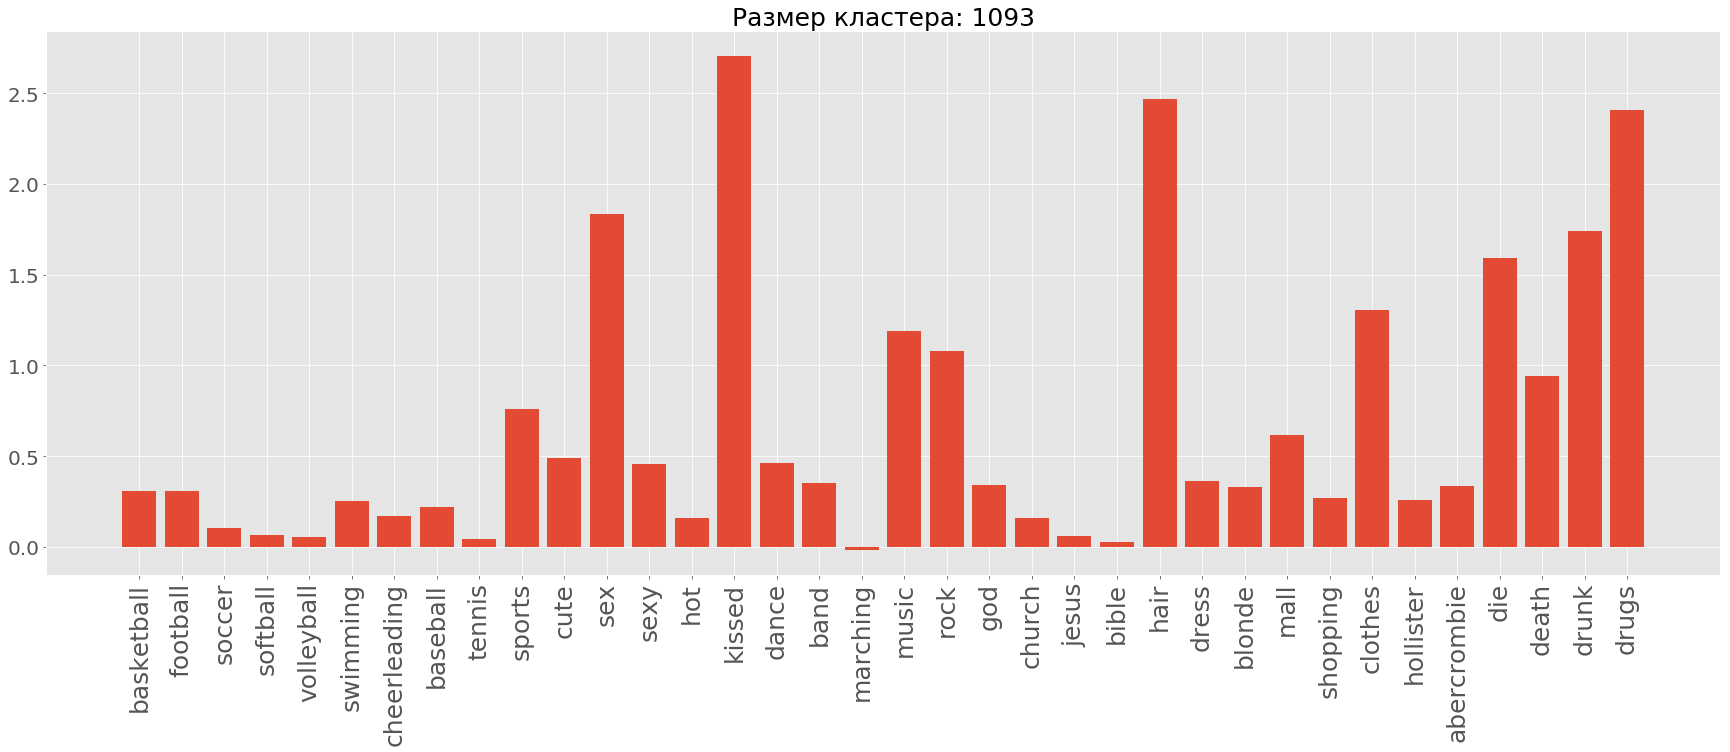

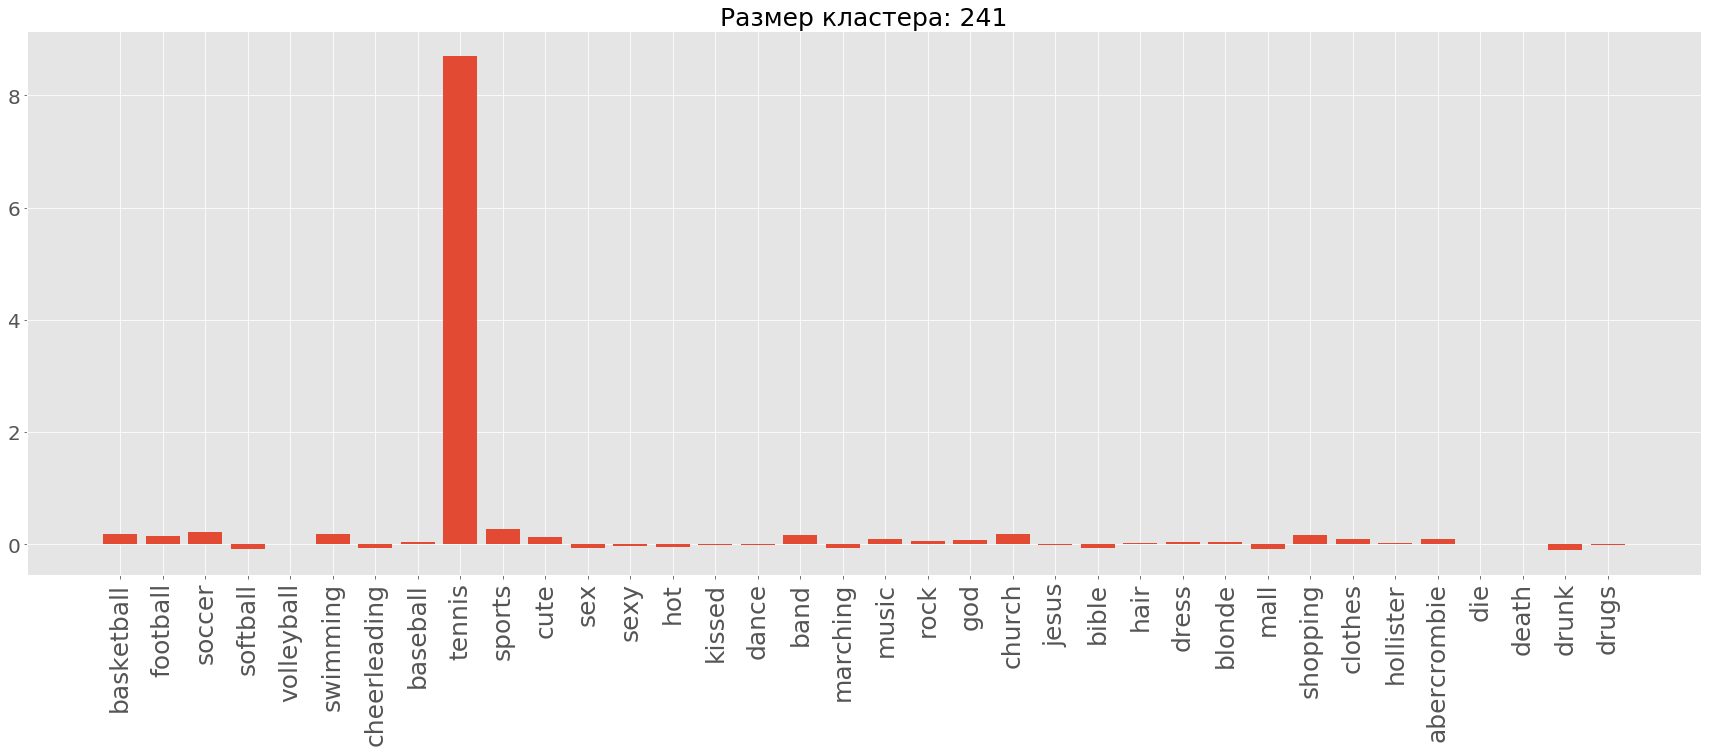

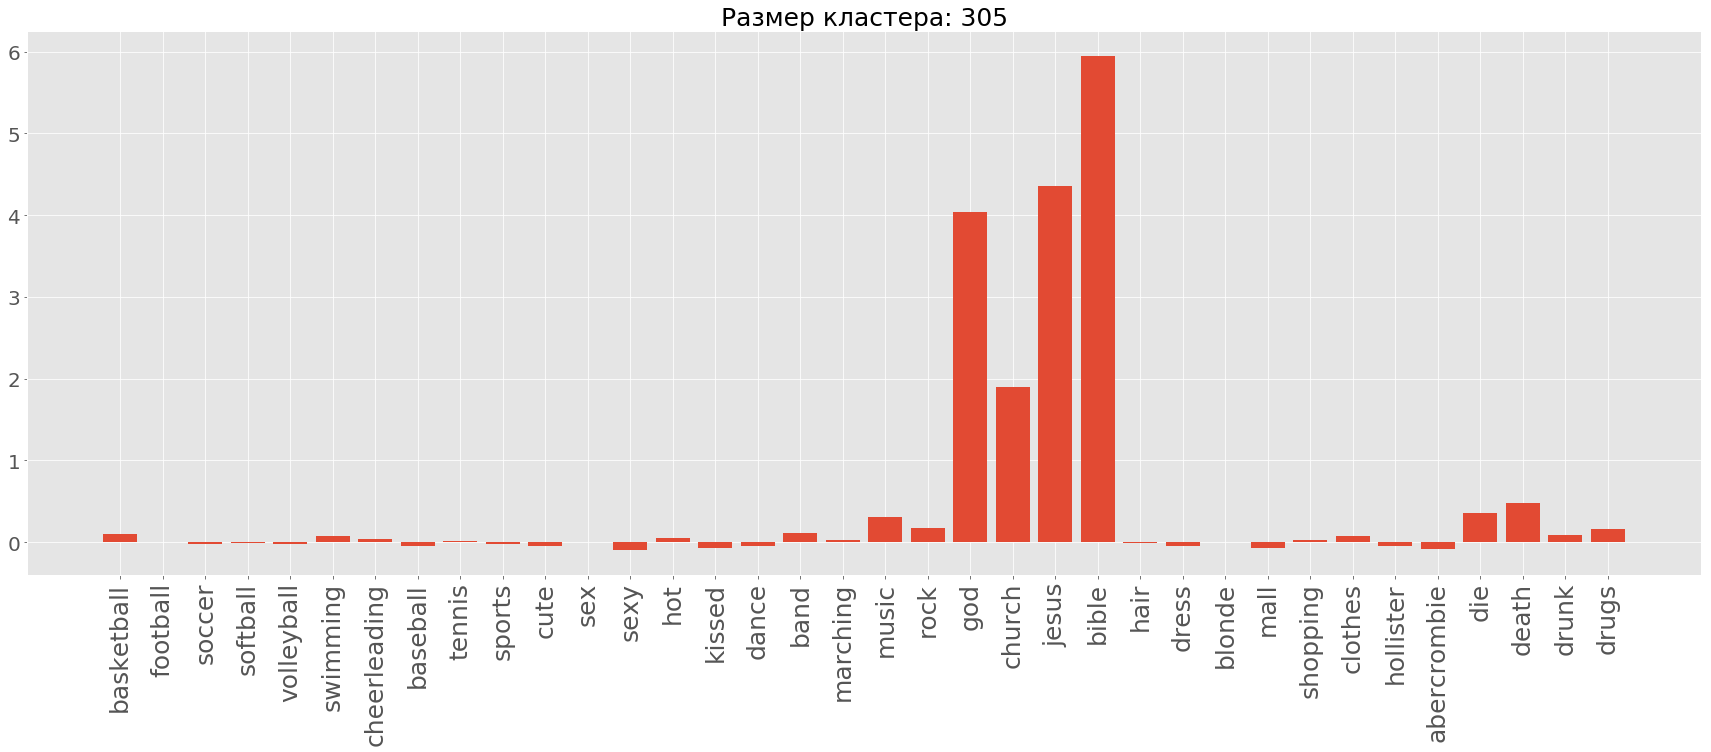

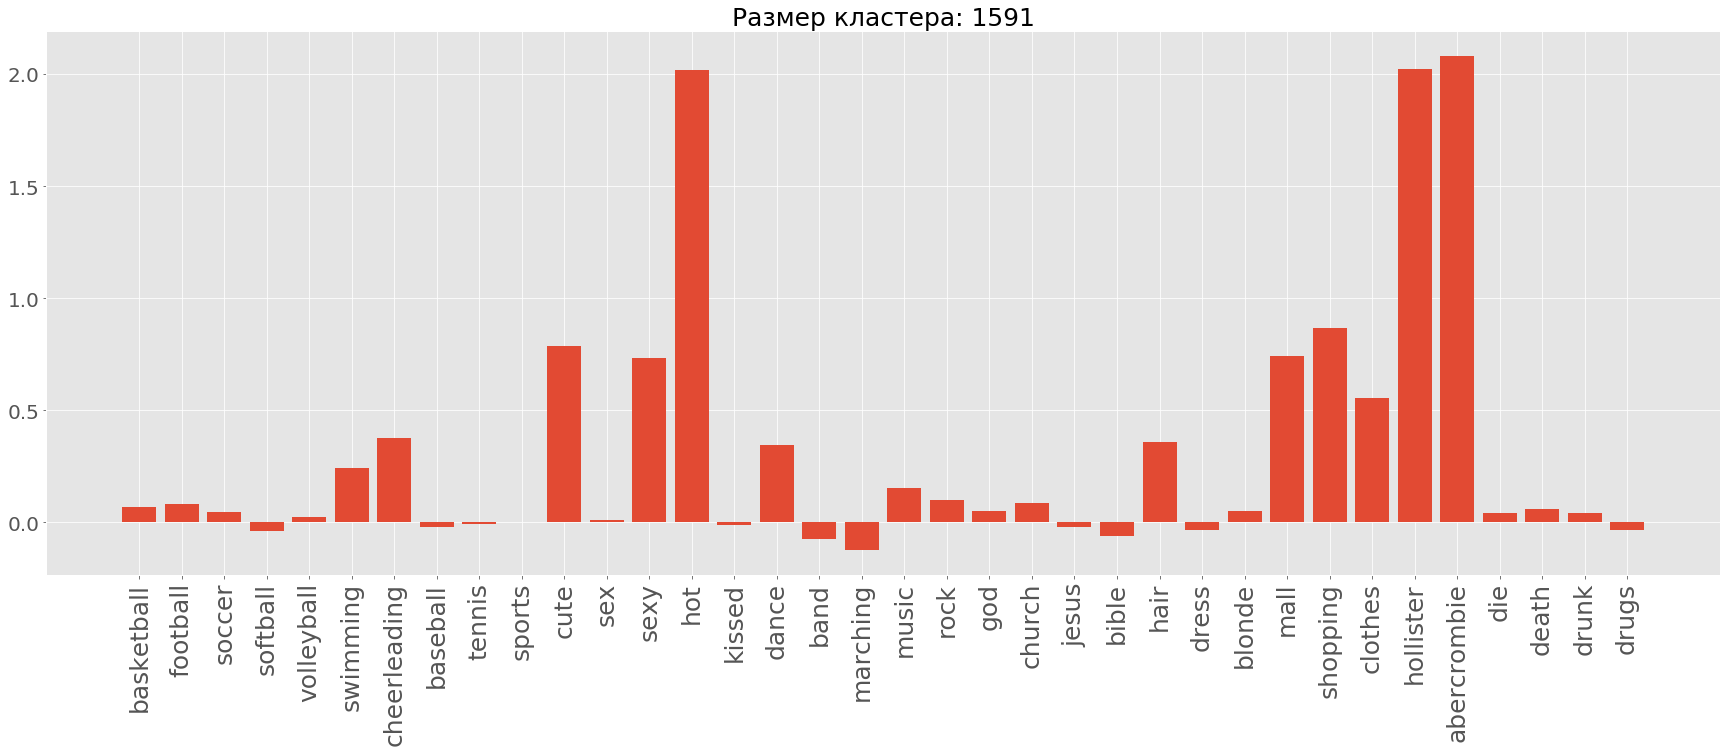

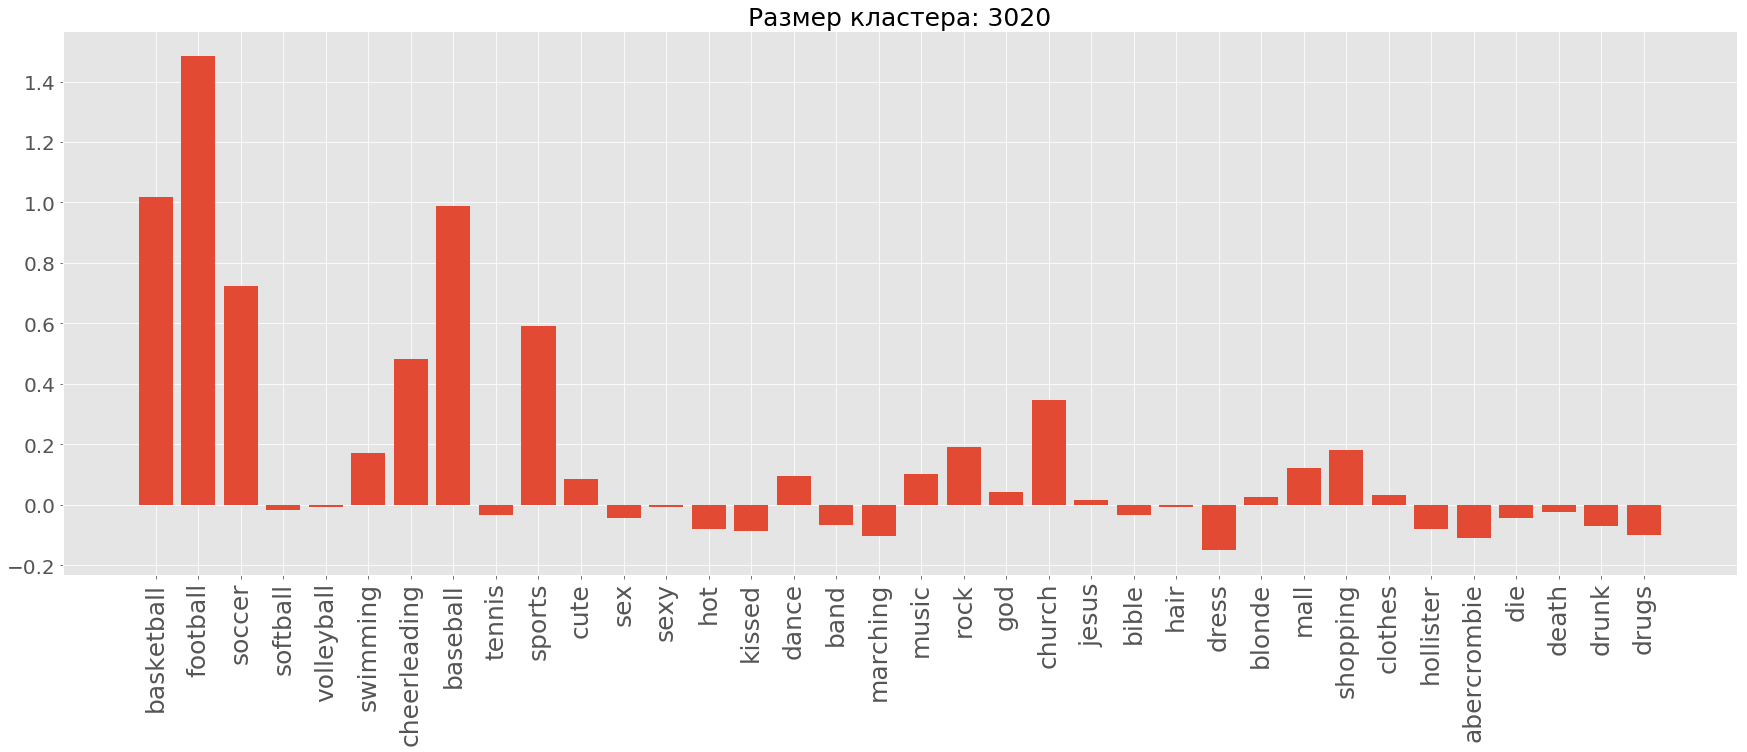

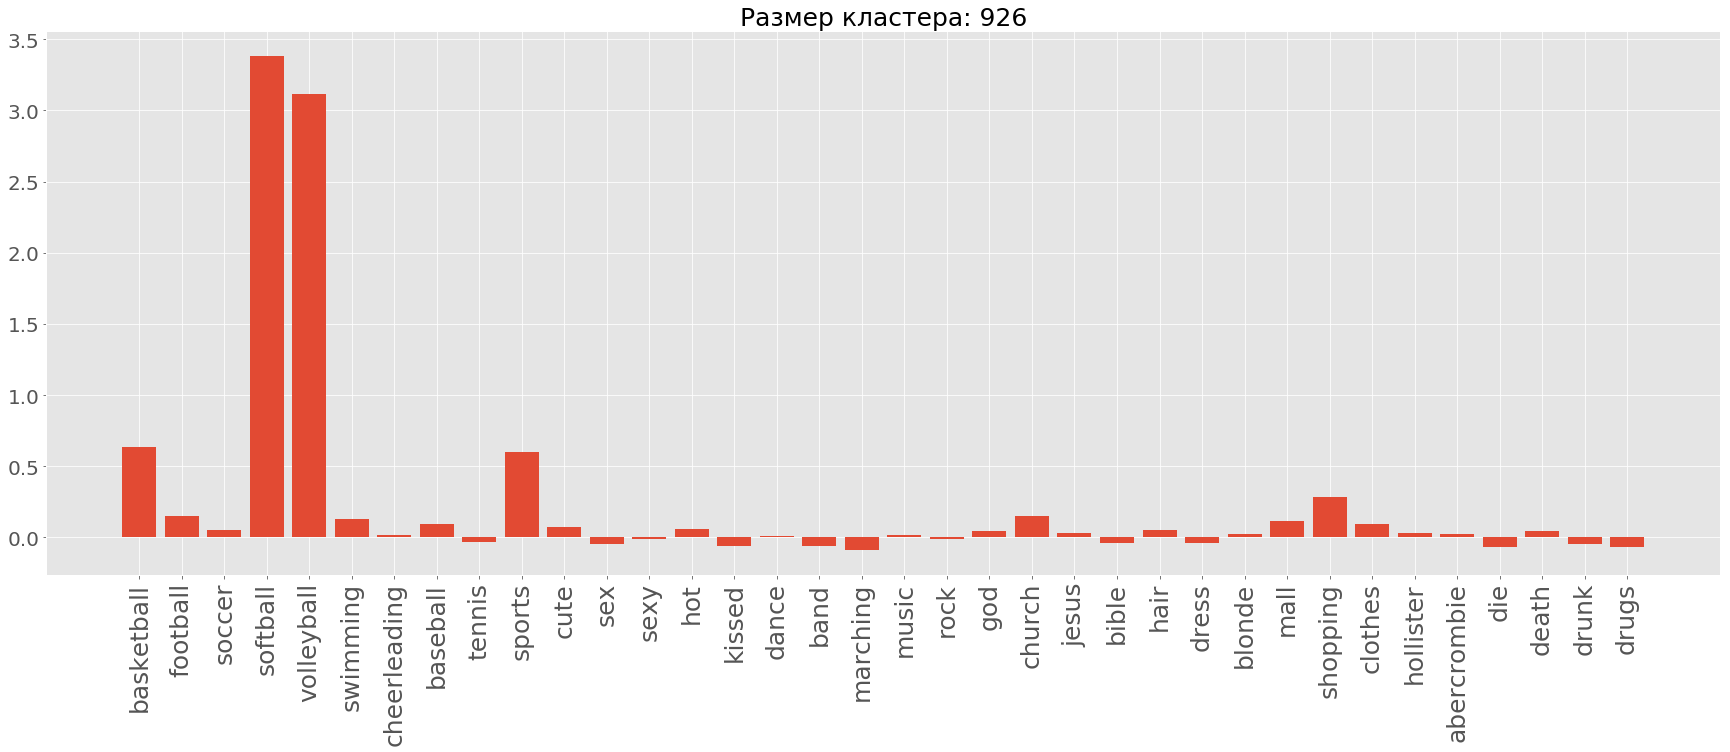

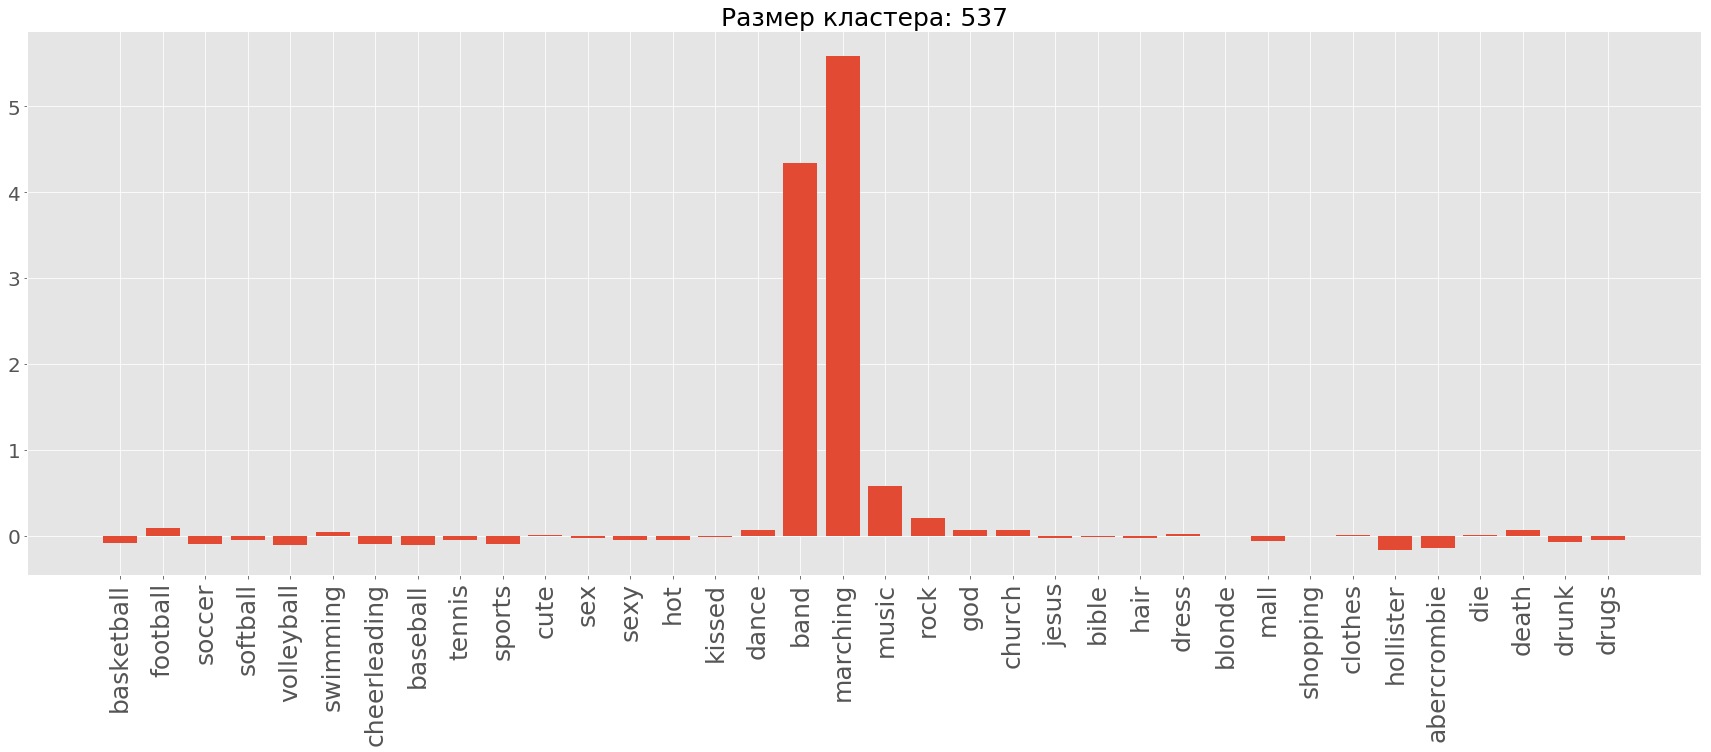

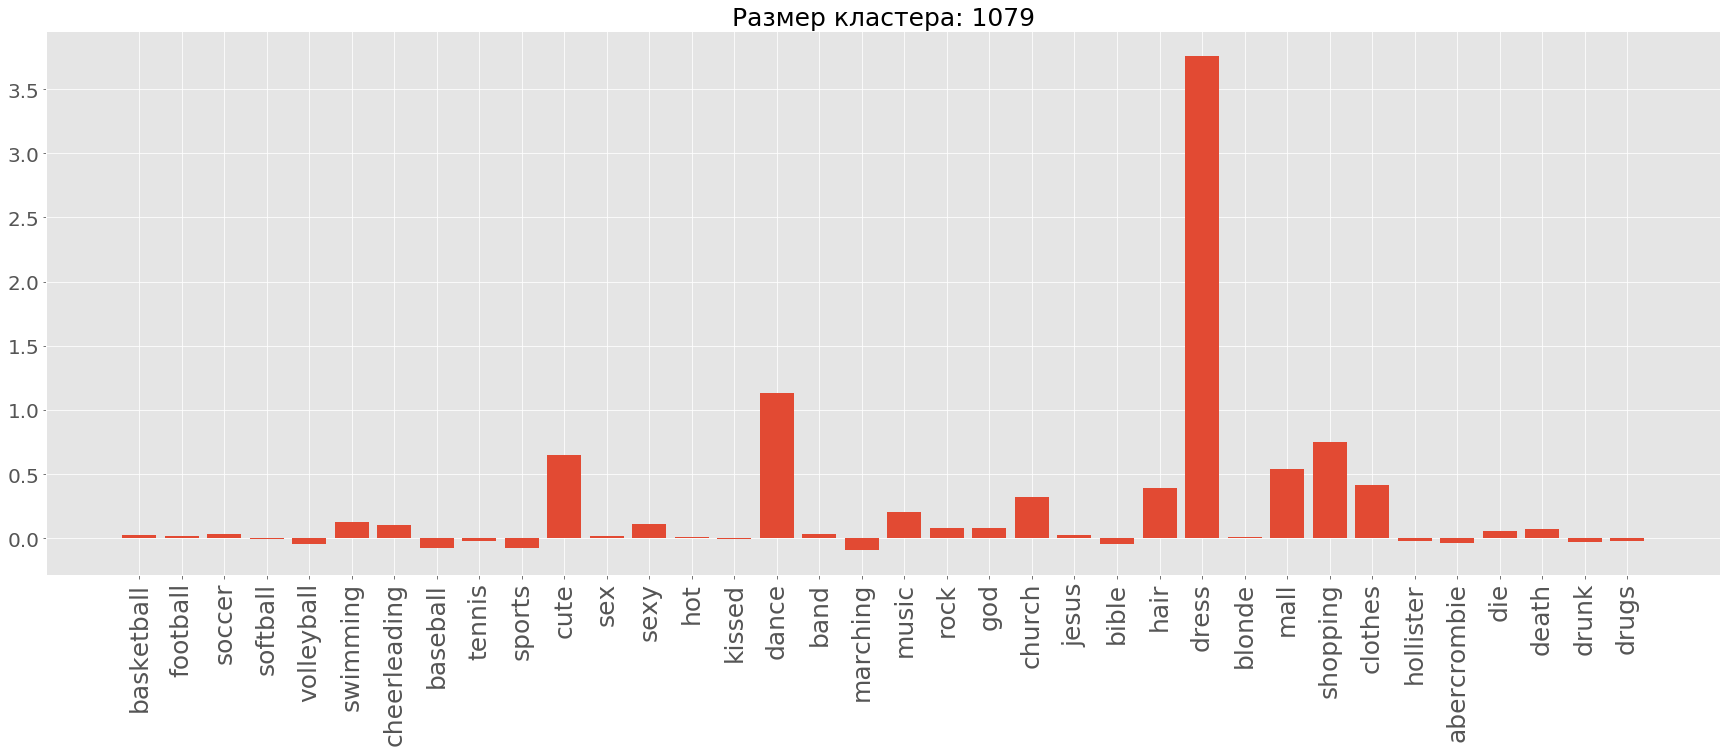

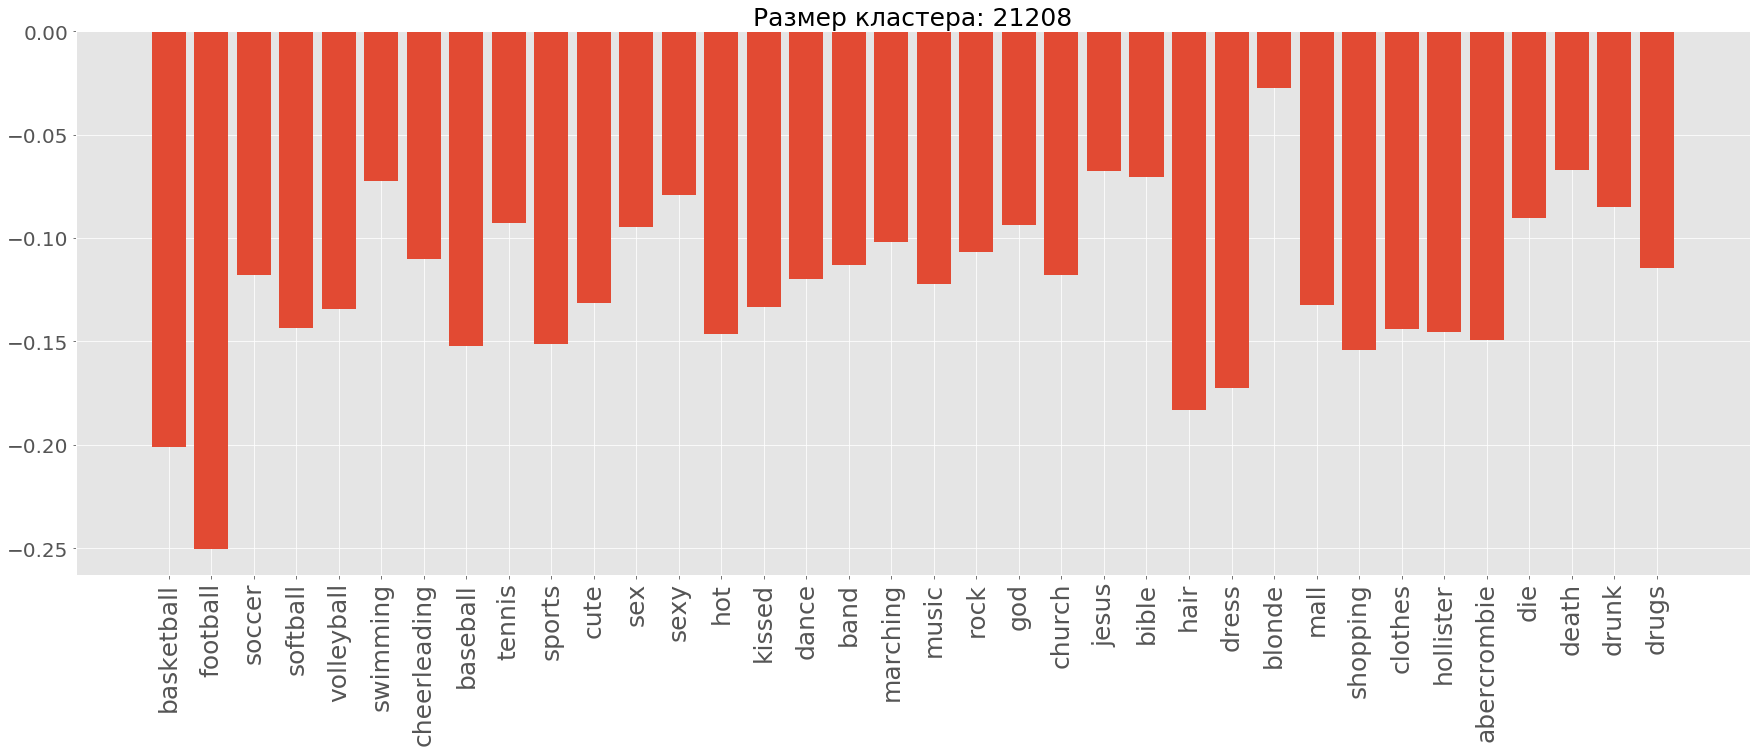

In [118]:
## MyKMeans
mykmeans = MyKmeans(k=n_clusters, random_state=123)
draw_plots(kmeans, df, n_clusters)
# кластеры довольно легко интерпретируются
# например в первом, где на первых местах kissed,hair,drugs,sex,drunk - ребята просто любят расслабиться
# второй кластер - tennis, возможно более менее профессиональные игроки в теннис
# затем верующие
# любители шоппинга
# спортсмены
# ребята которым нравится softball, volleyball, скорее всего любители активного отдыха
# band, marching - любят военную тему
# dress, dance, shopping, clothes, cute - кластер с милыми девушками
# самый последний кластер - размер: 21208 - те, кто не проставил интересы 

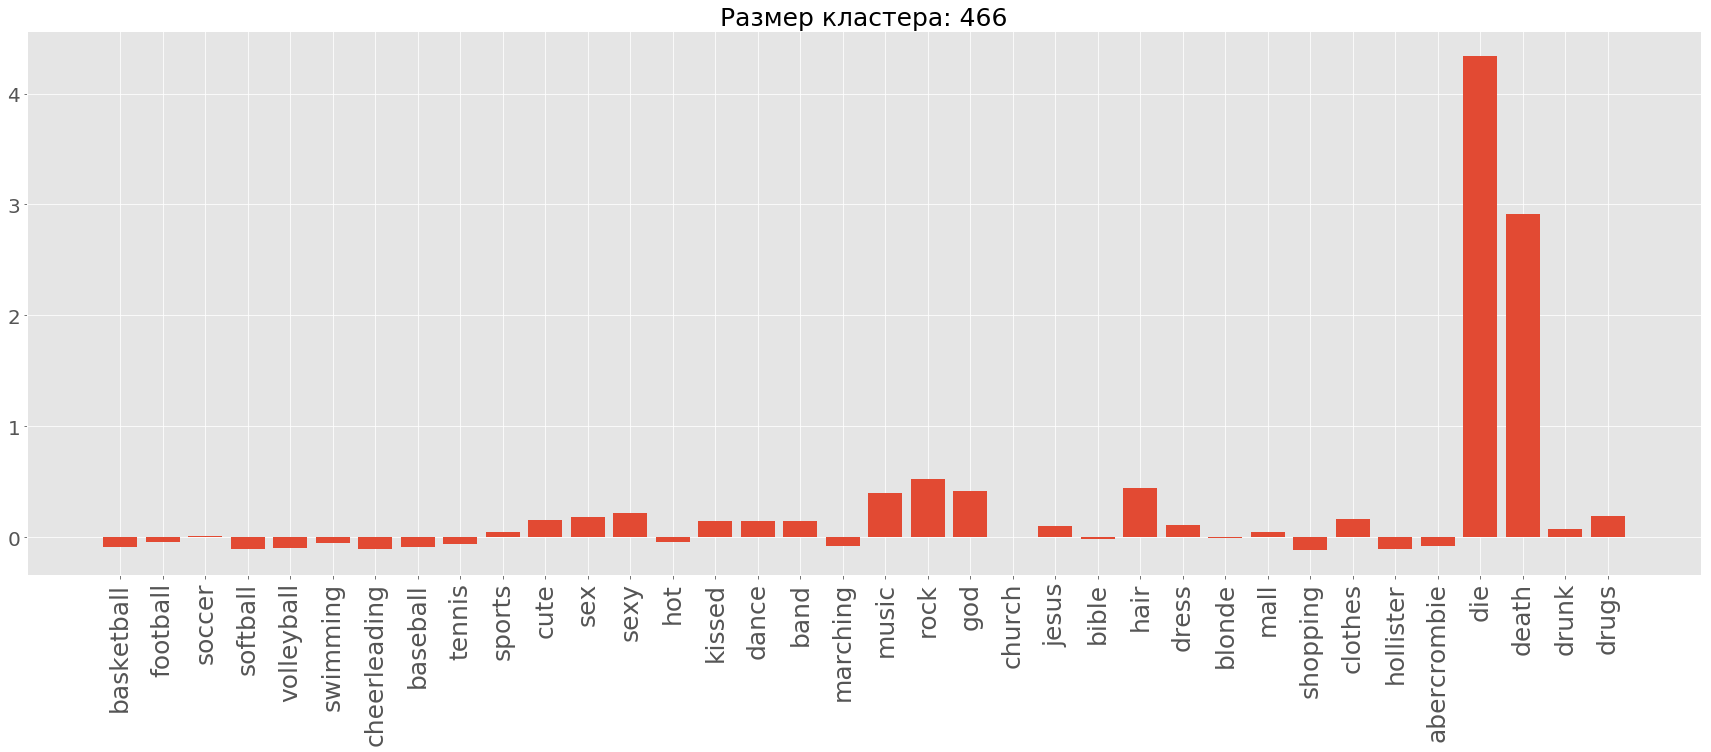

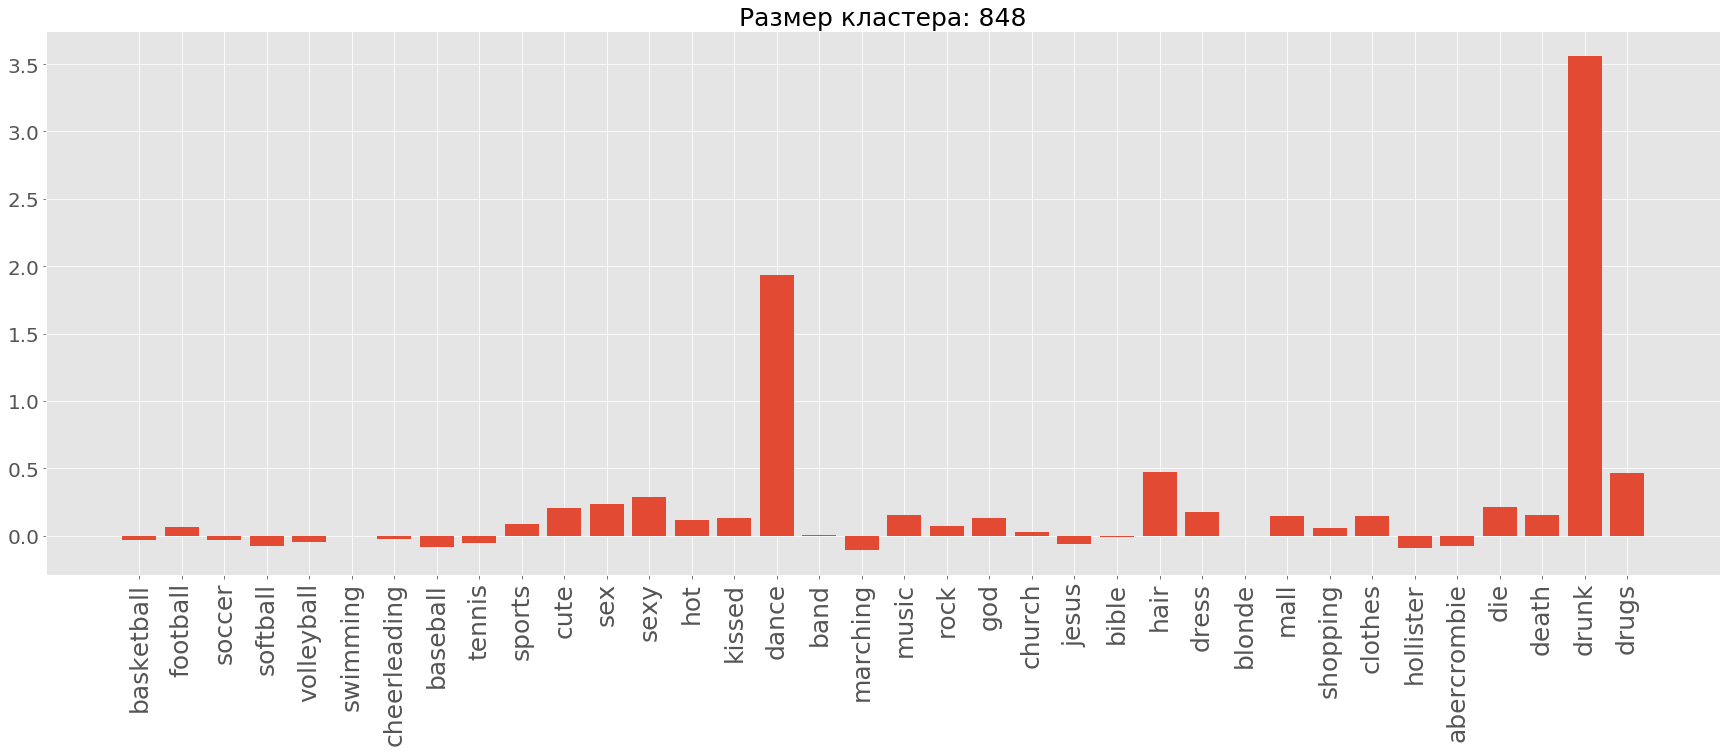

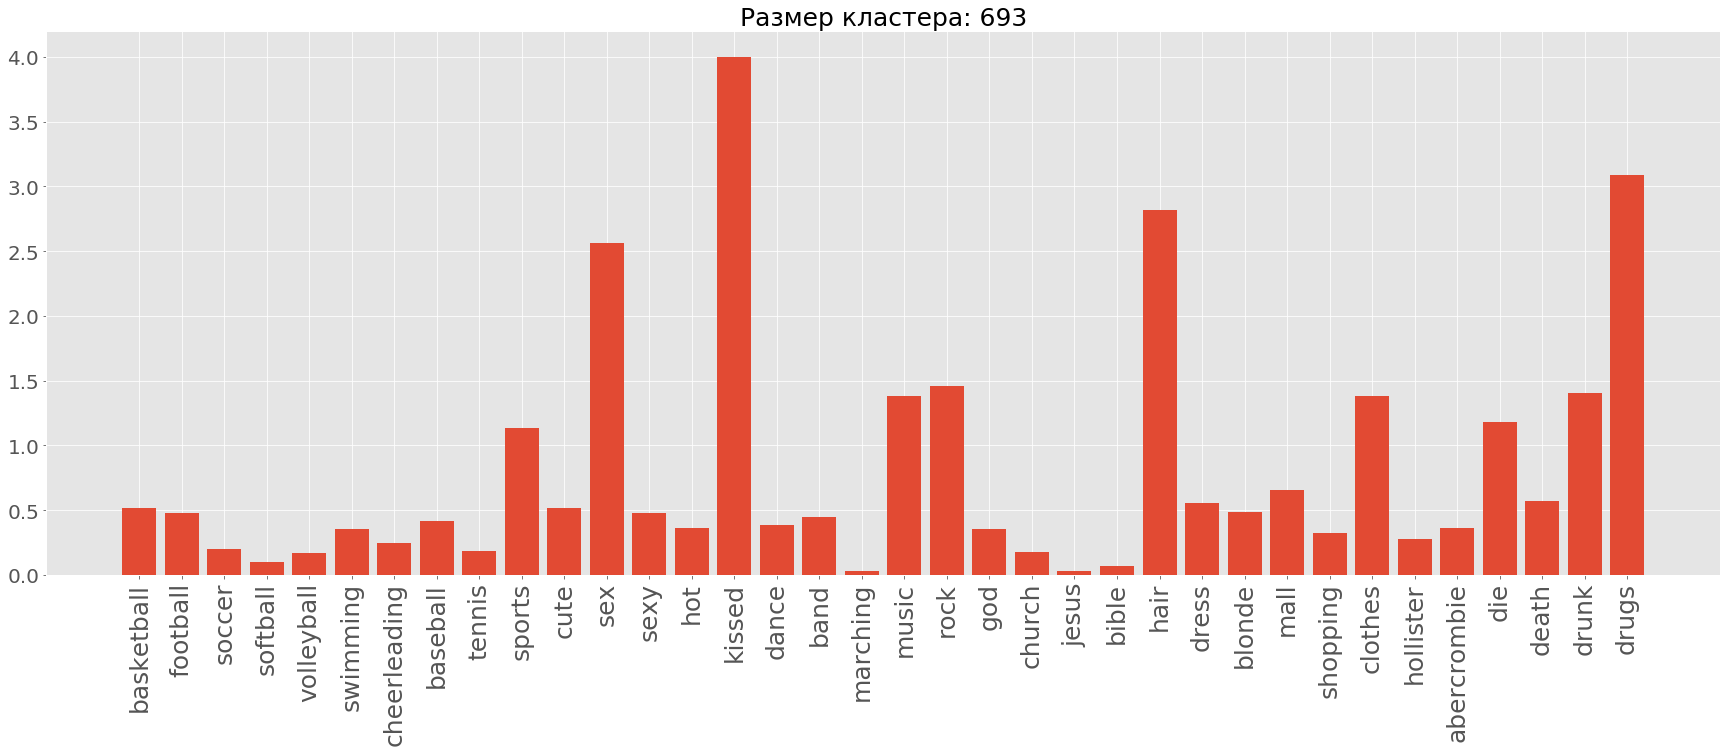

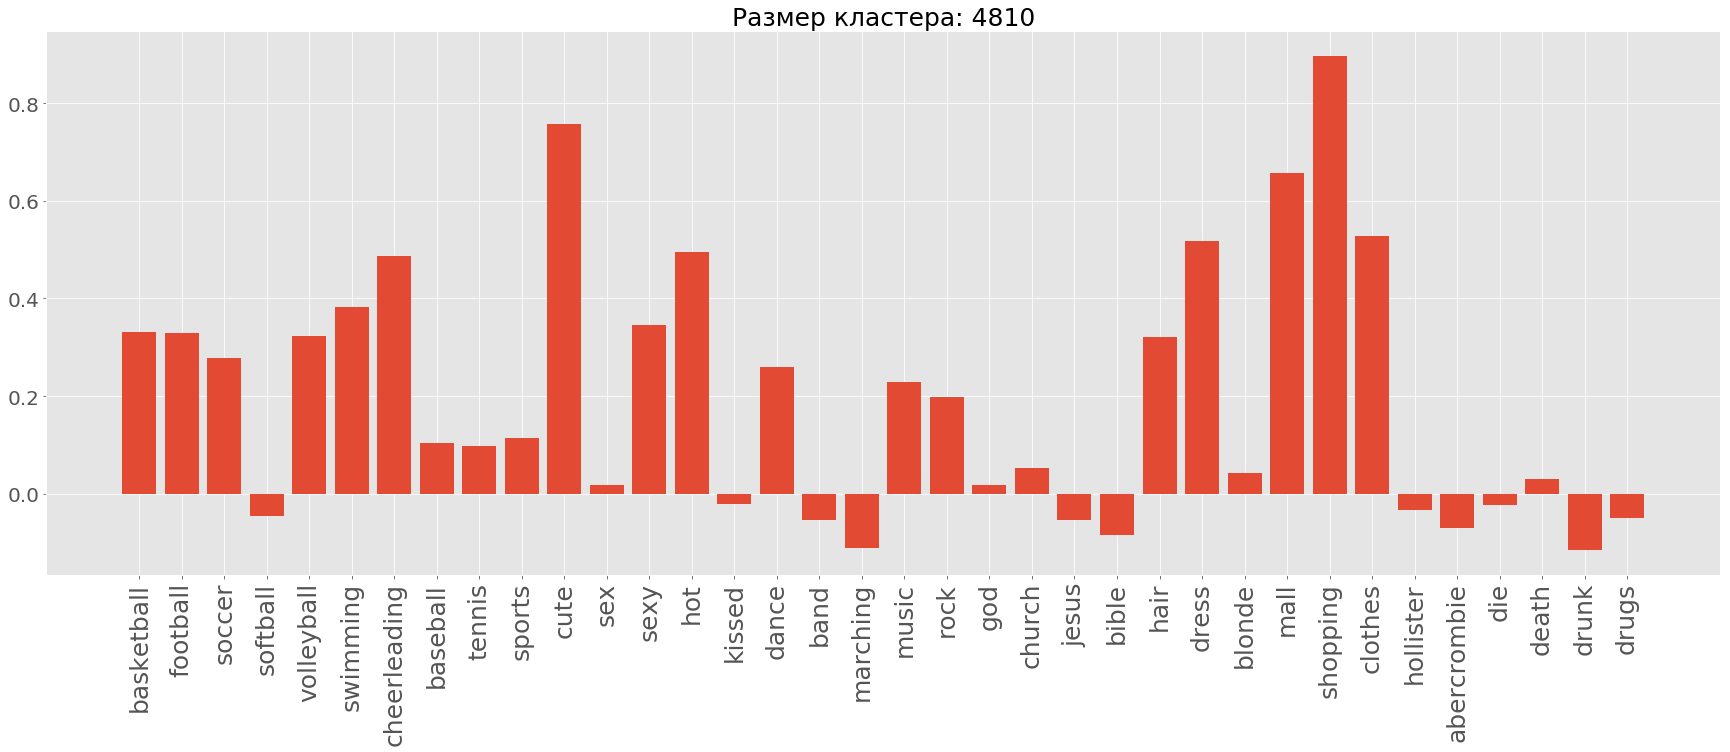

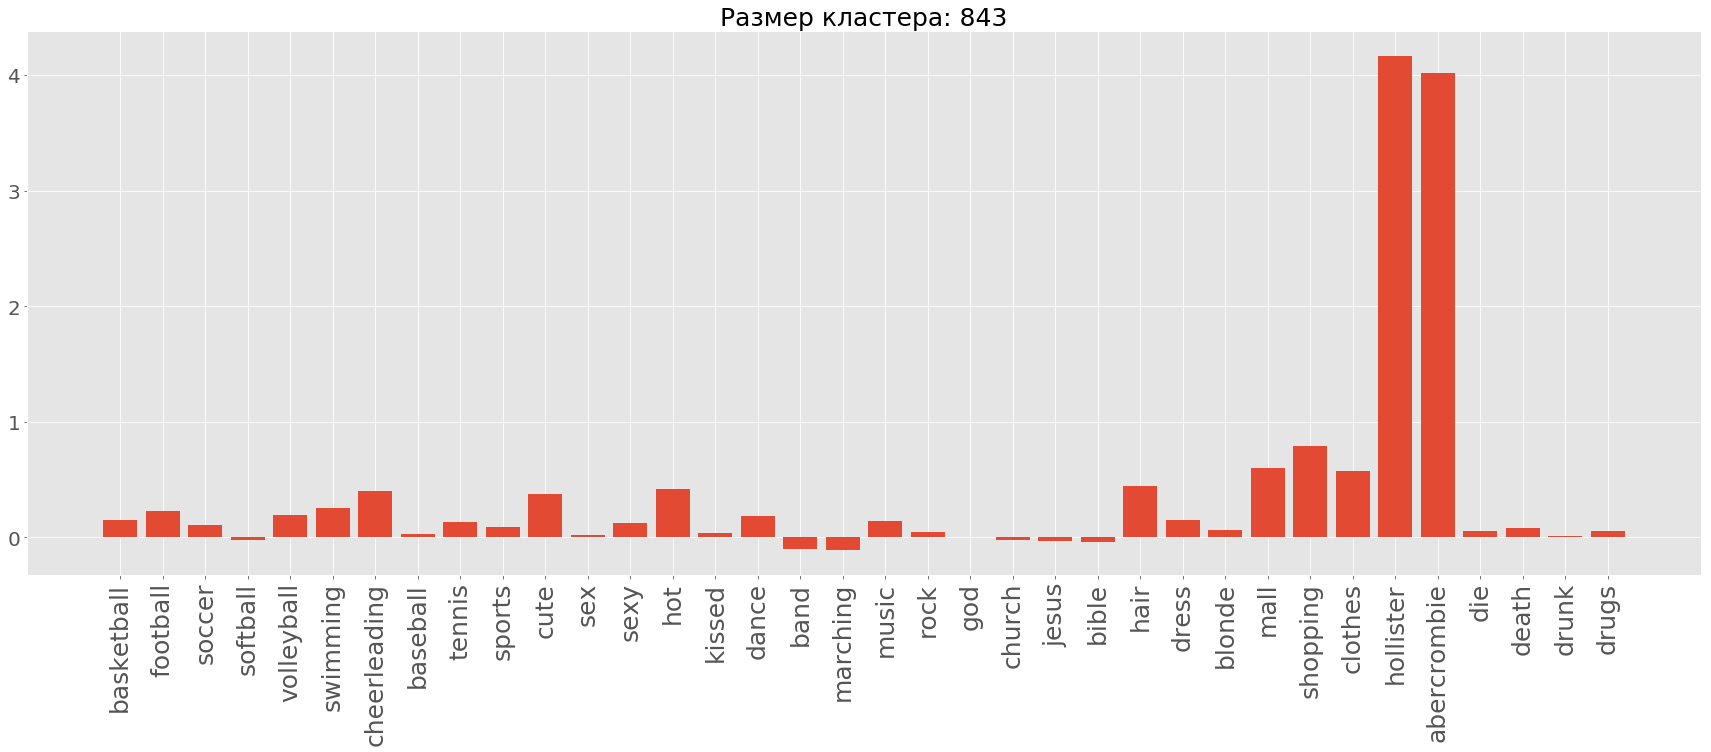

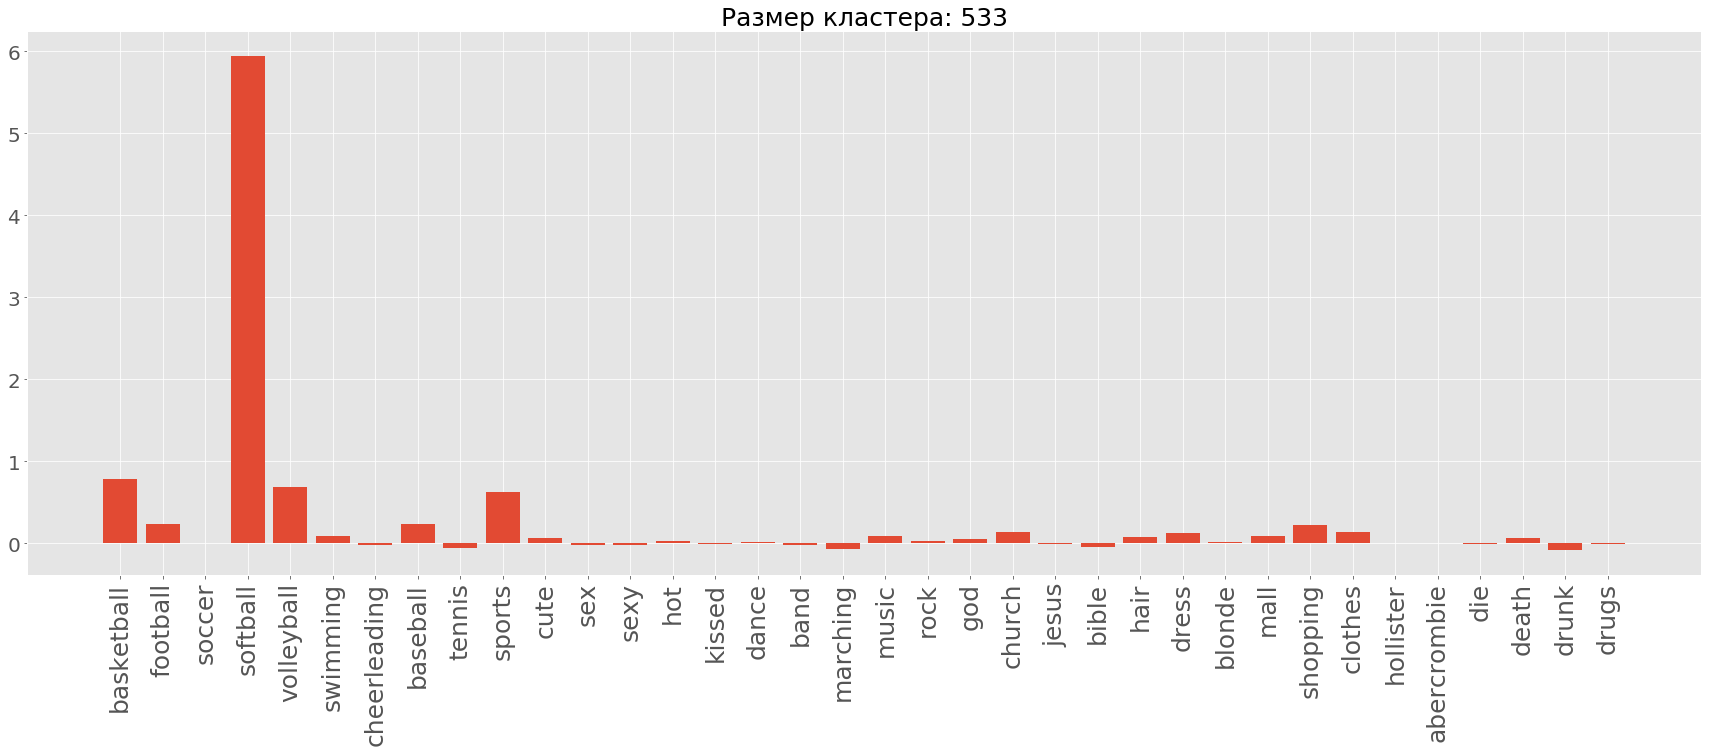

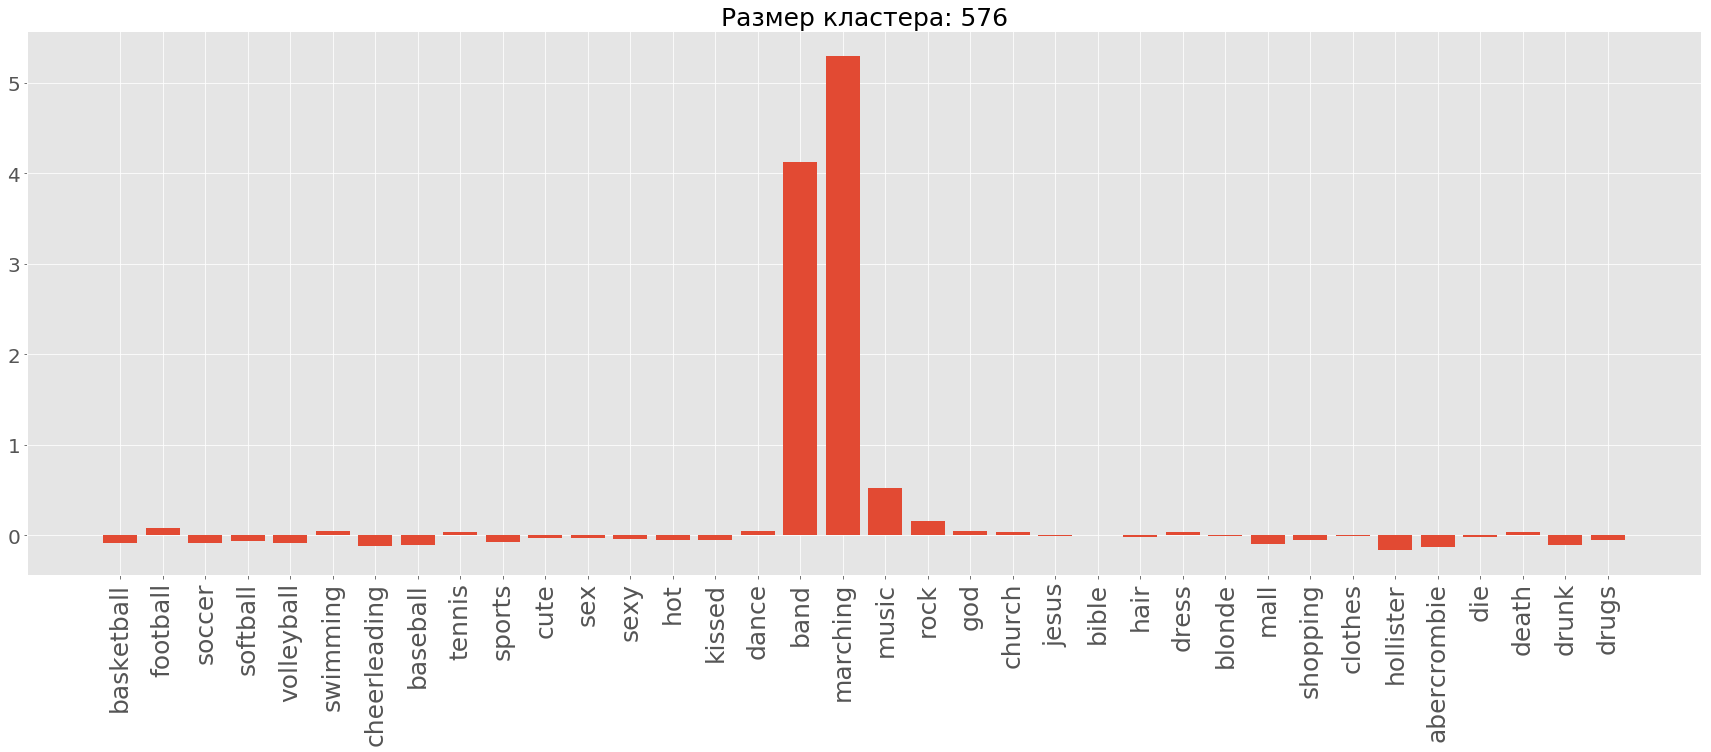

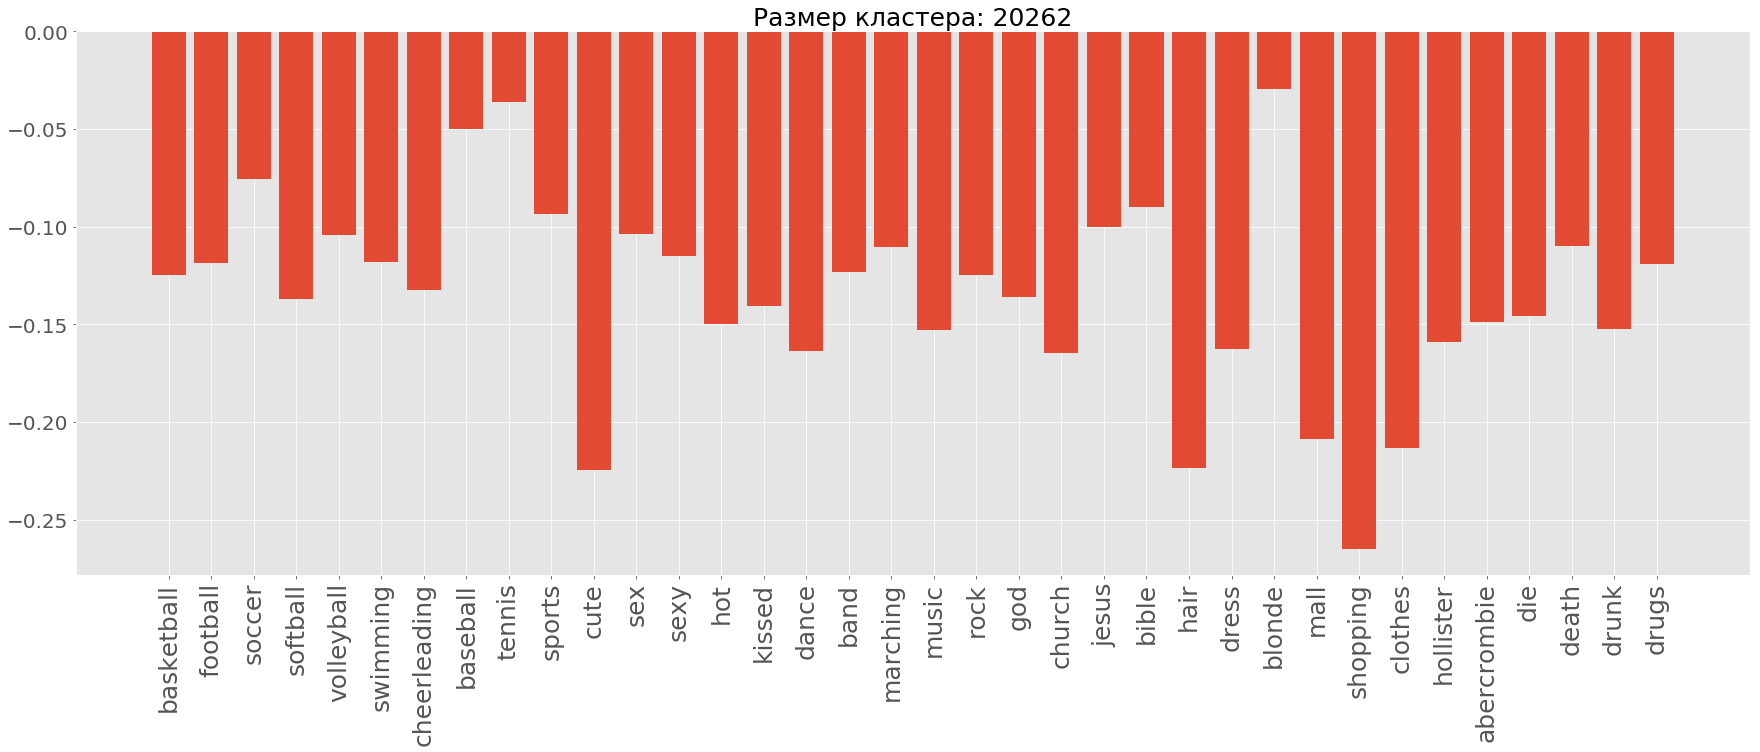

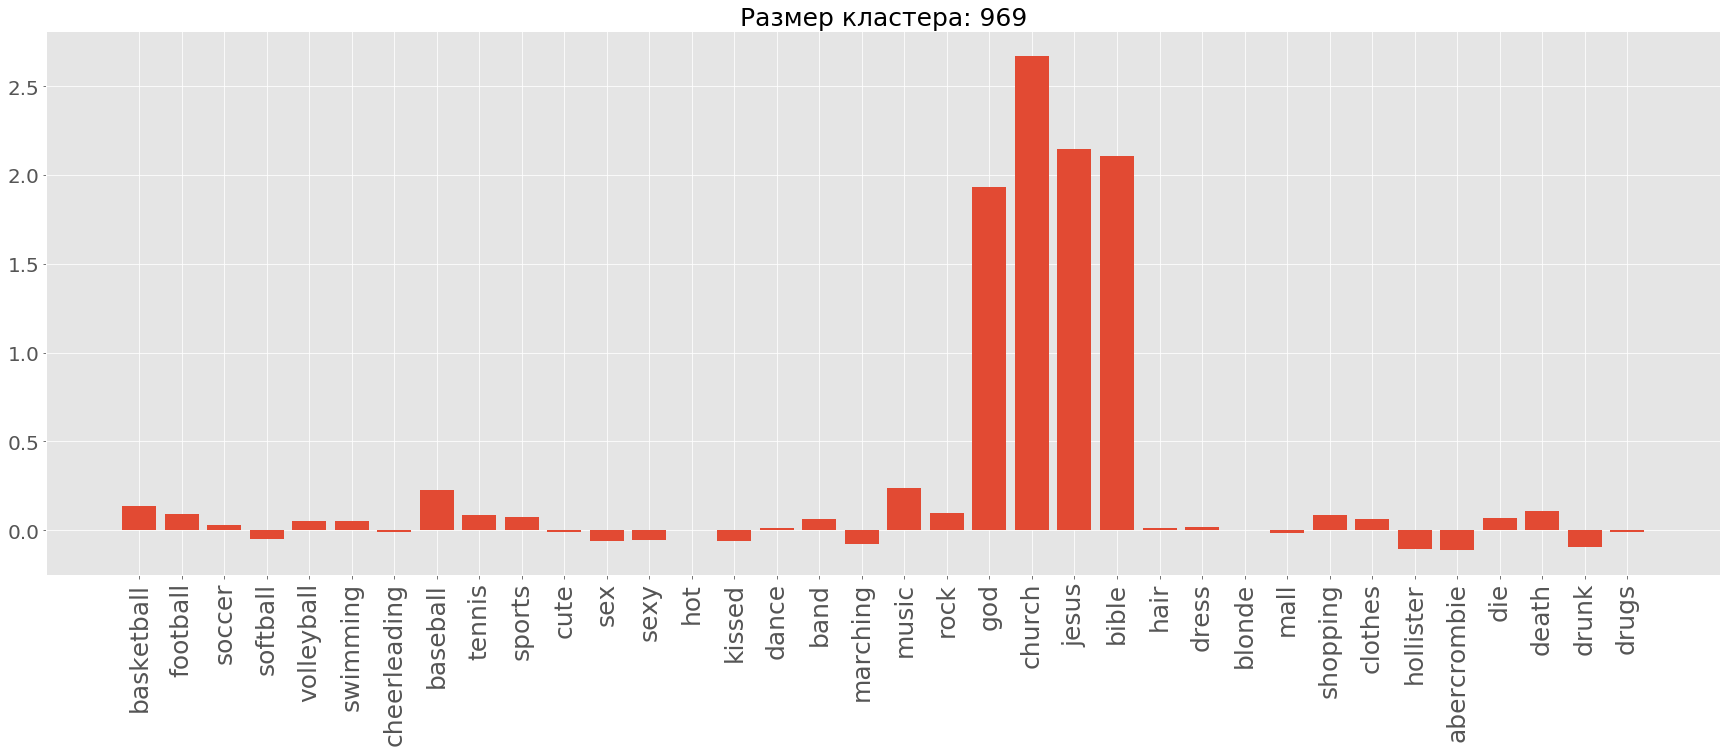

In [123]:
## MyKMeans++
mykmeans = MyKmeans(k=n_clusters, init='k-means', random_state=1234)
draw_plots(kmeans, df, n_clusters)
# die, death - возможно люди с депрессией
# drunk, dance - люди которые отдыхают определленным образом
# kissed, drugs, hair, sex и много другого - любят разносторонне отдохнуть
# shopping, cute, mall, clothes - любители шопинга, но не очень интенсивного 
#       (показатели интереса не очень большие)
# abercrombie, hollister - профессиональные любители шопинга, заинтересованные в конкретном бренде
# softball - скорее всего более менее профессионально/хорошо играют в софтбол
# band, marching - любители военной темы
# ребята, забывшие проставить интересы
# верующие

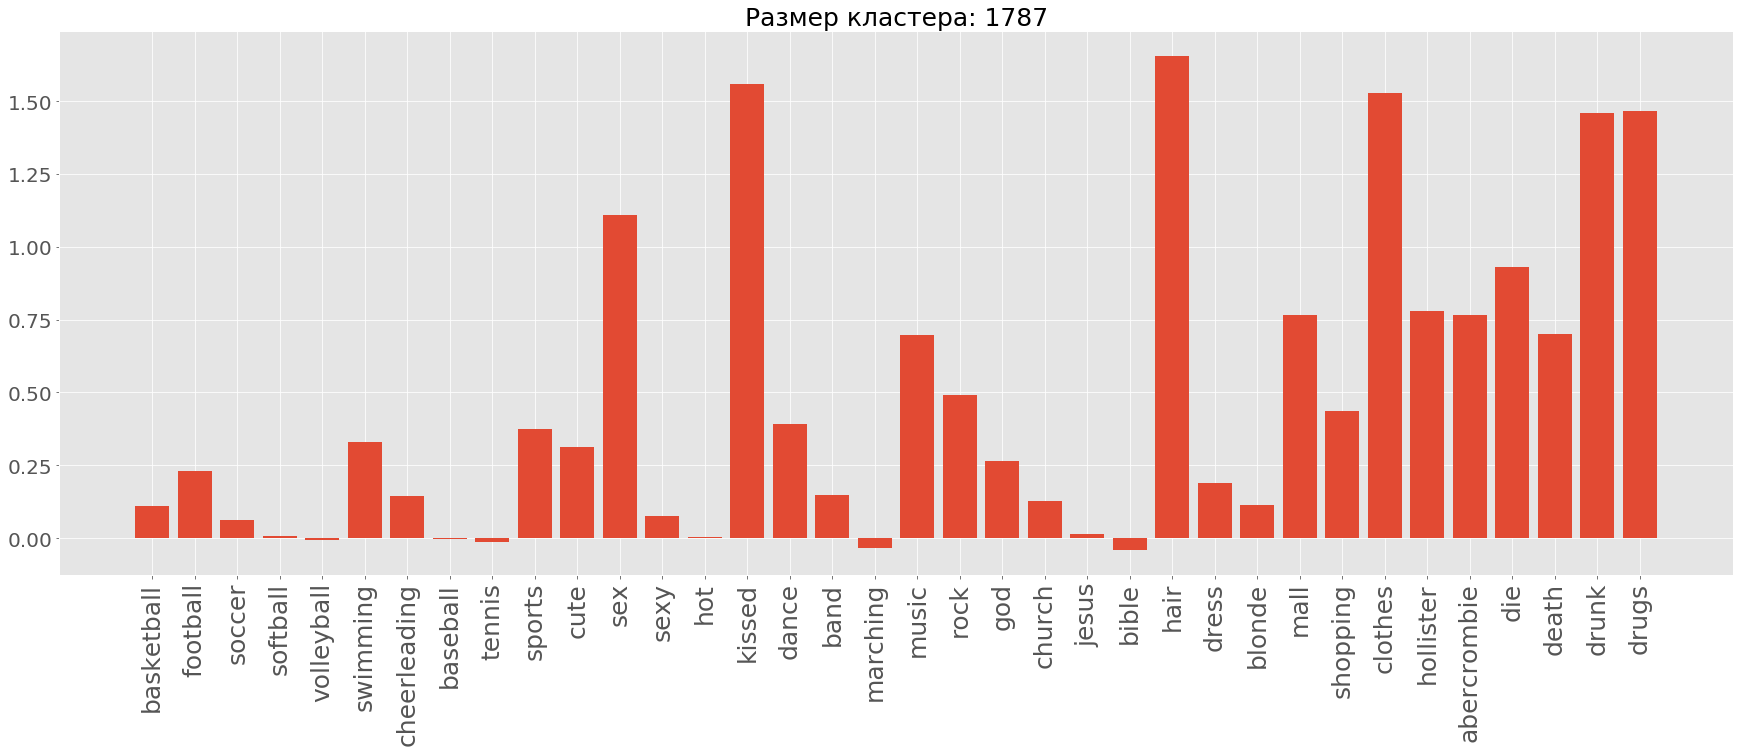

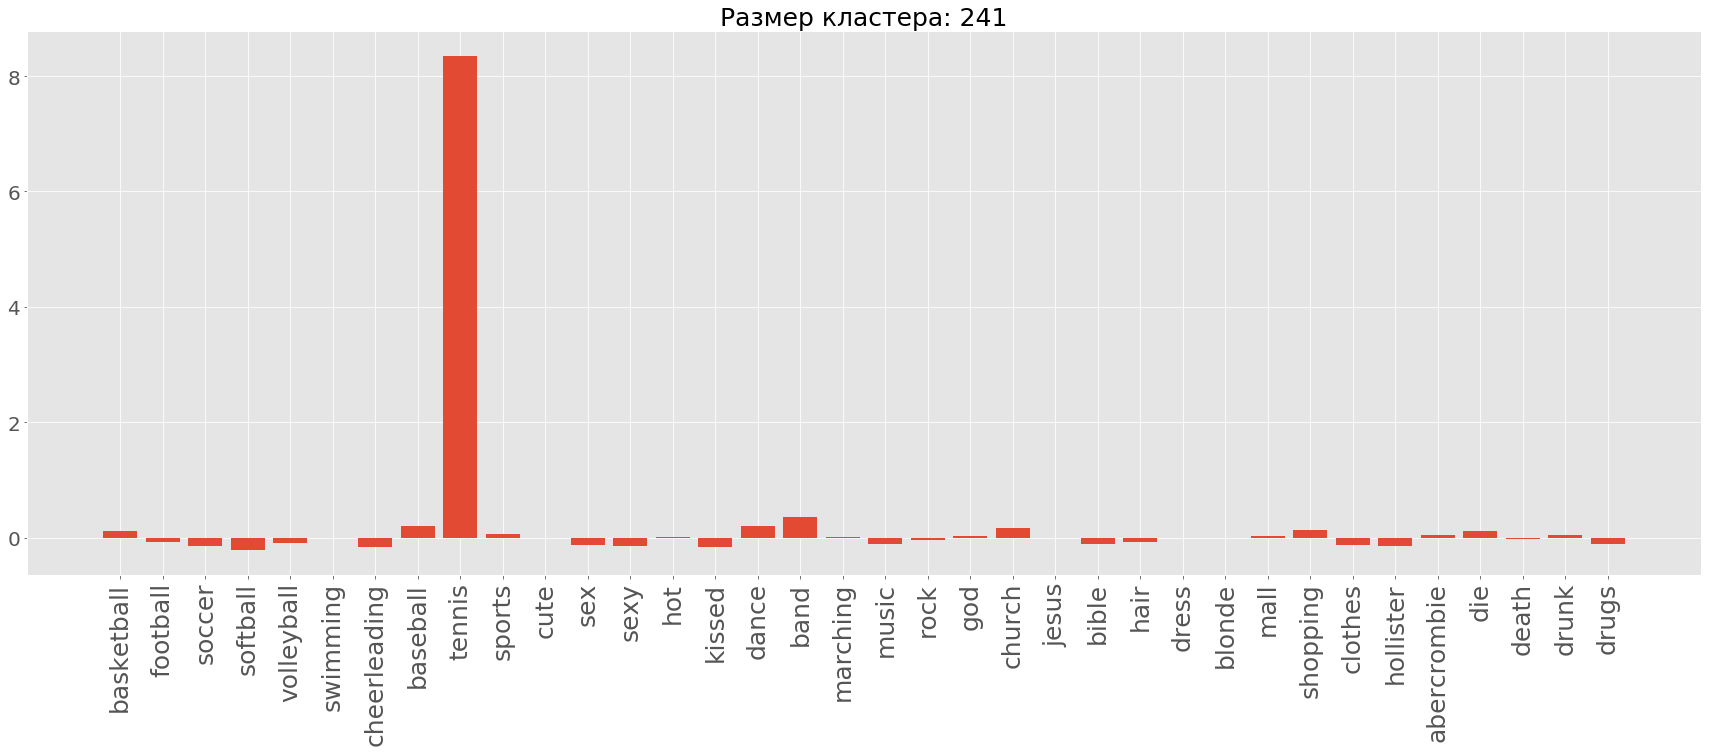

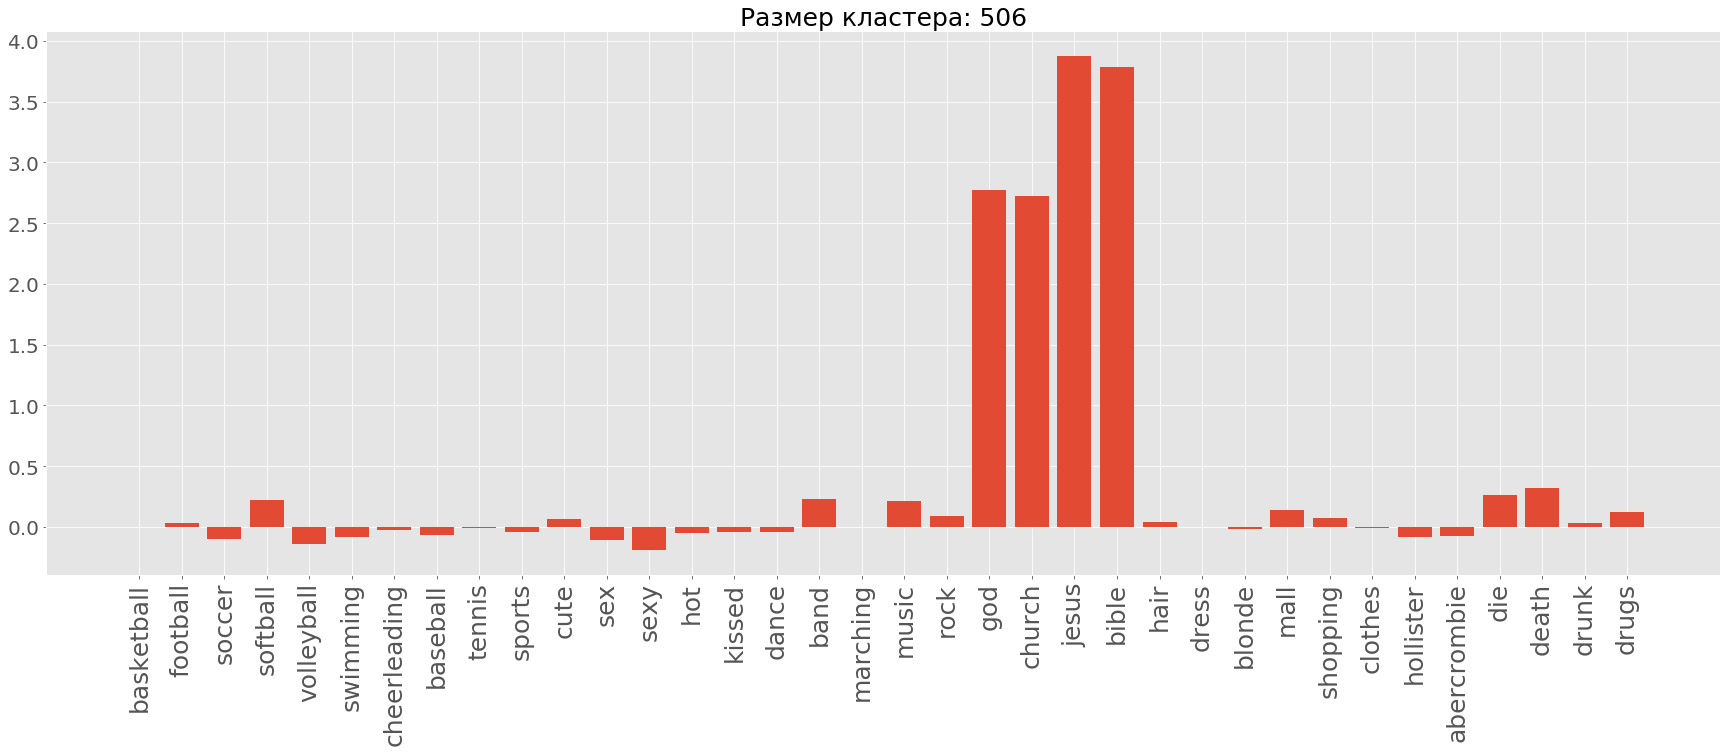

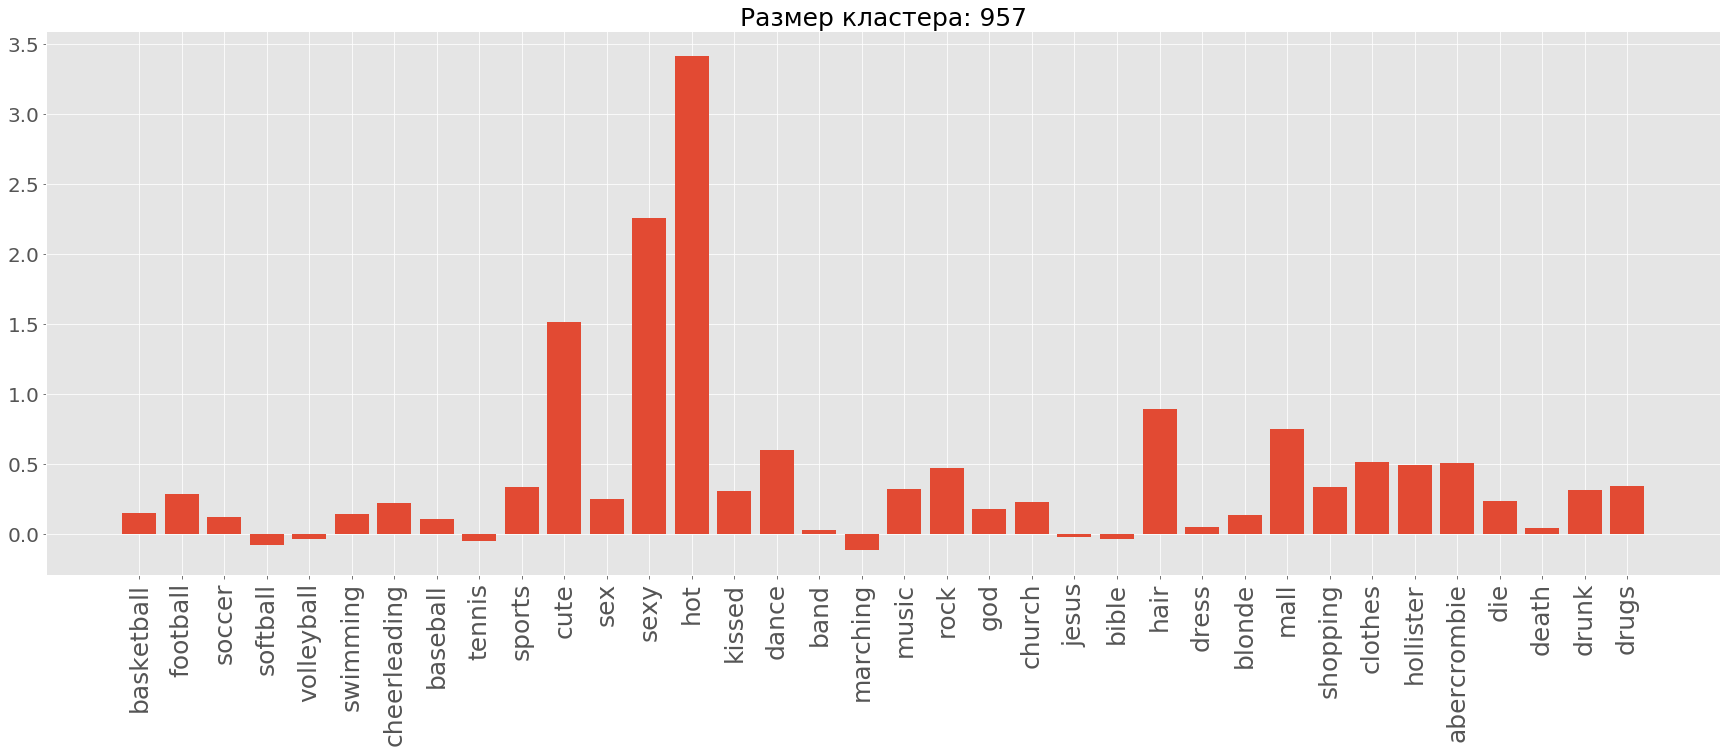

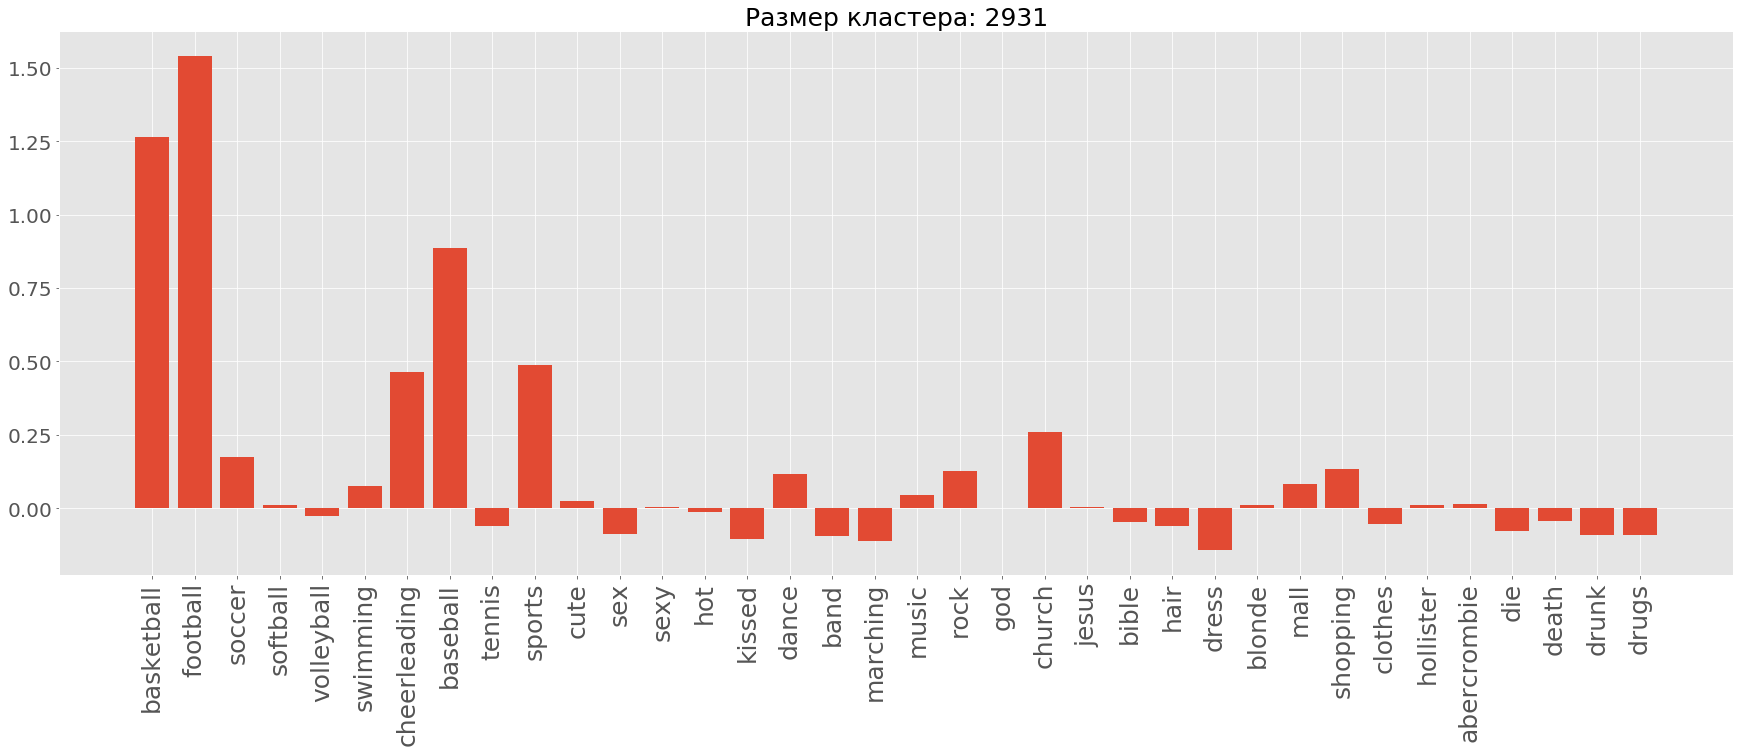

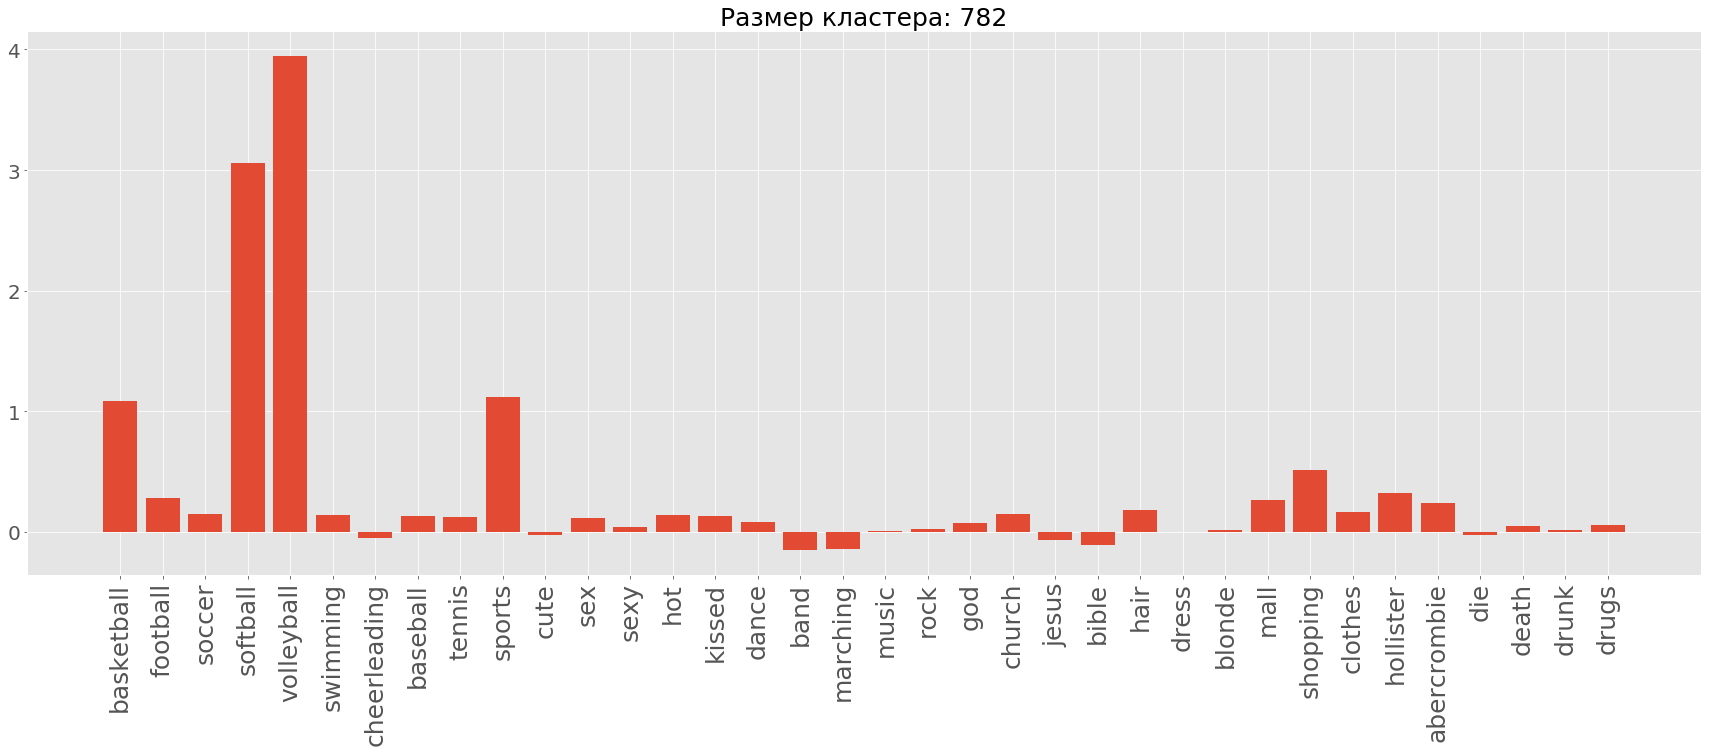

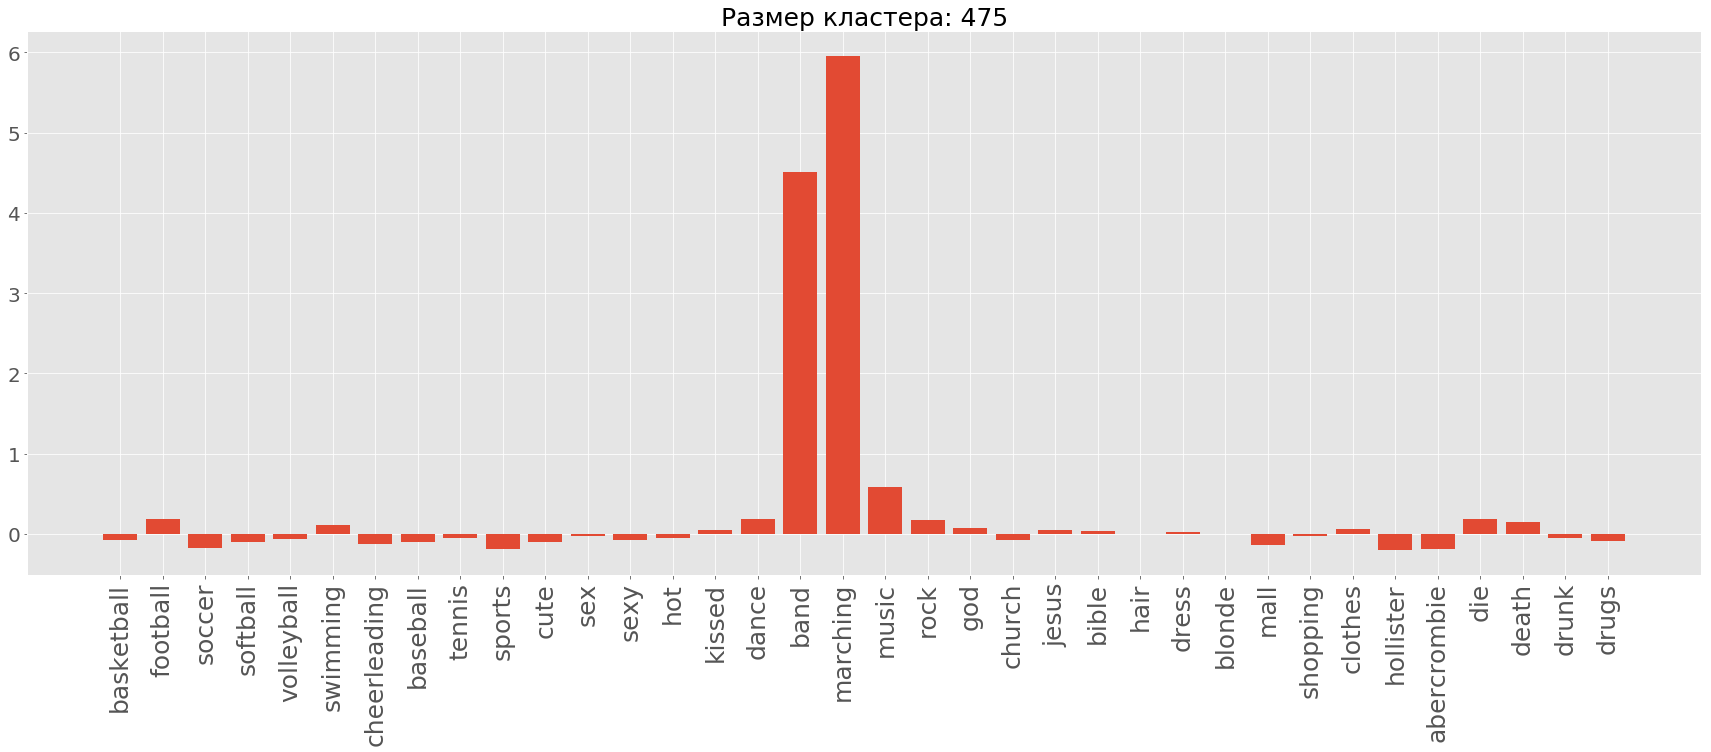

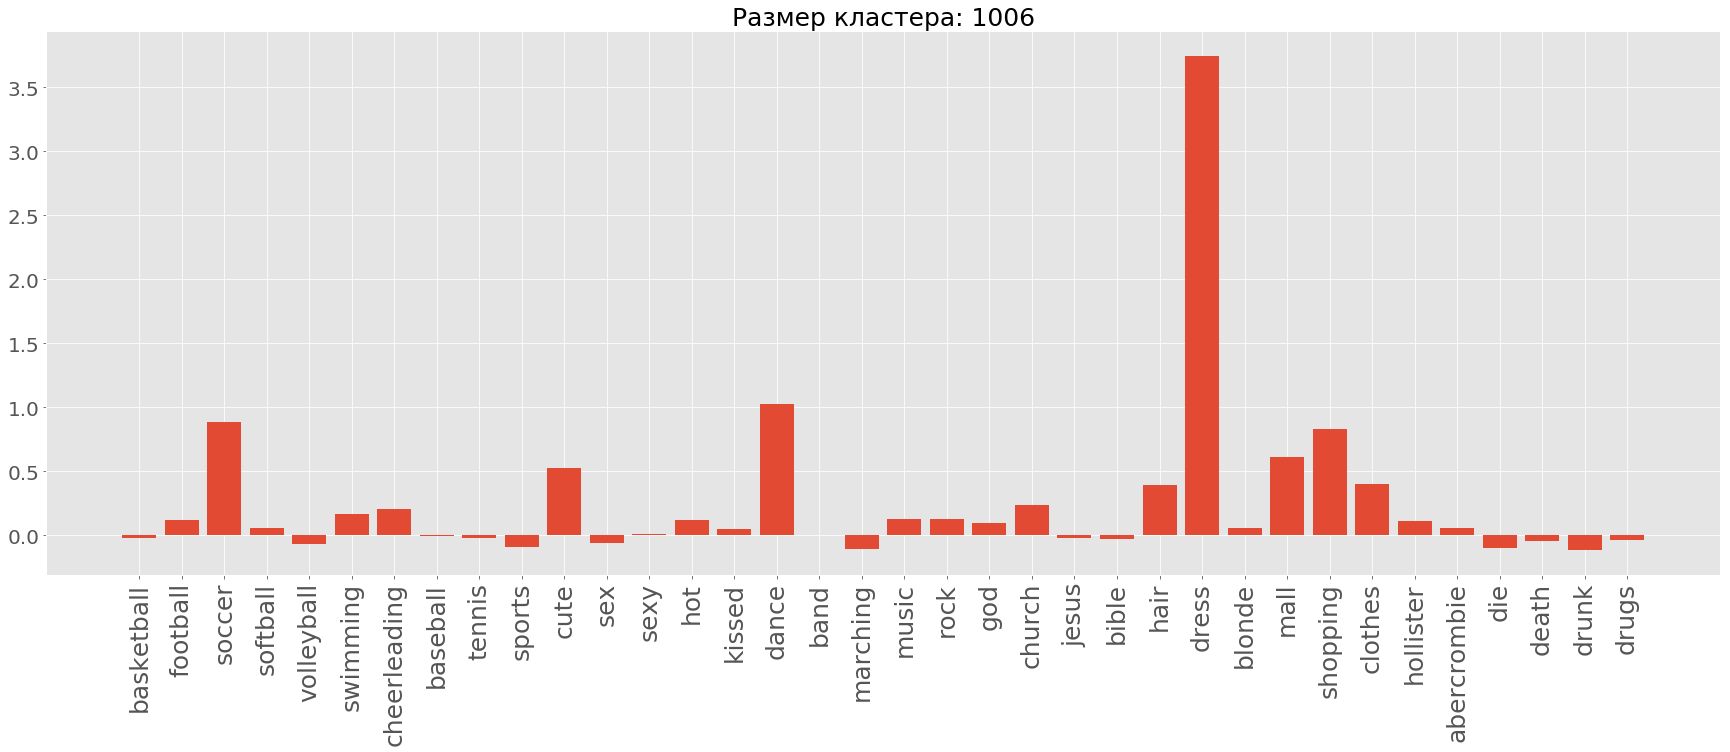

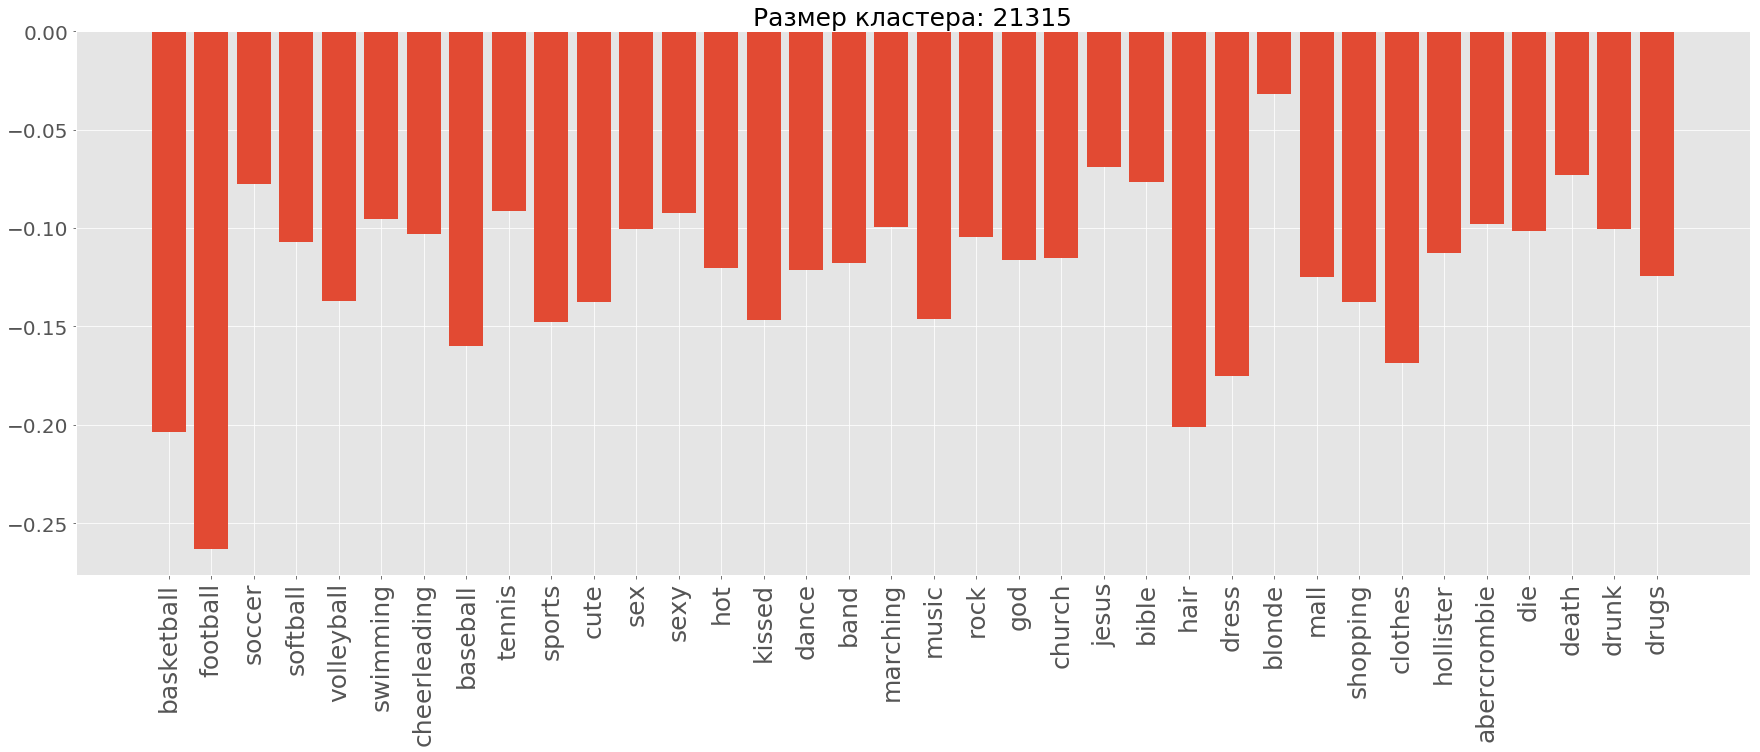

In [124]:
## MyKMeans с MiniBatchMyKMeans
mykmeans = MiniBatchKMeans(k=n_clusters, random_state=123)
draw_plots(kmeans, df, n_clusters)
# графики практически совпадают с MyKMeans
# (то есть освновные лидеры кластеров аналогичные)

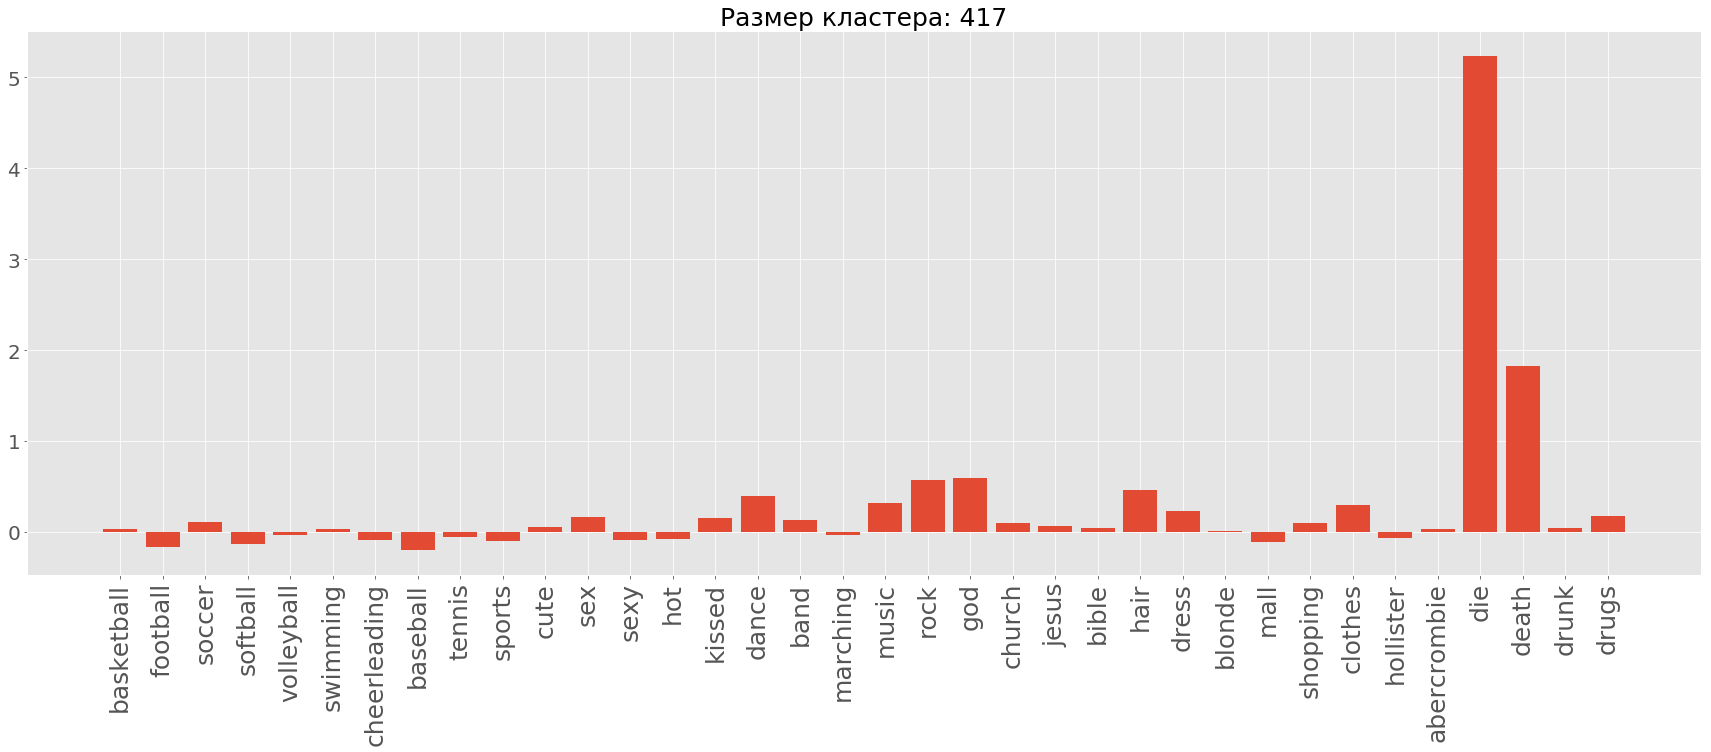

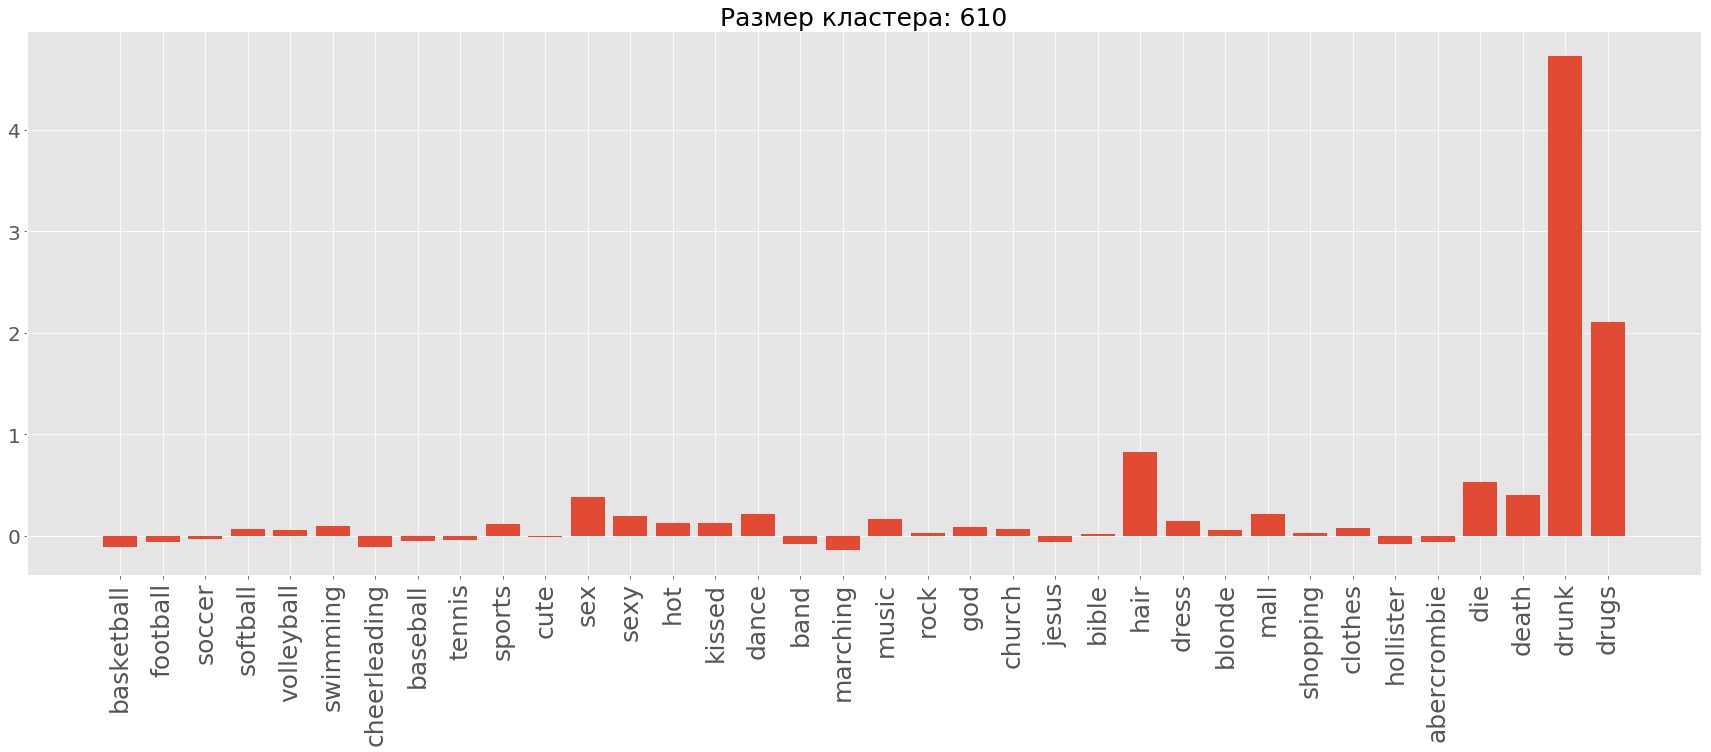

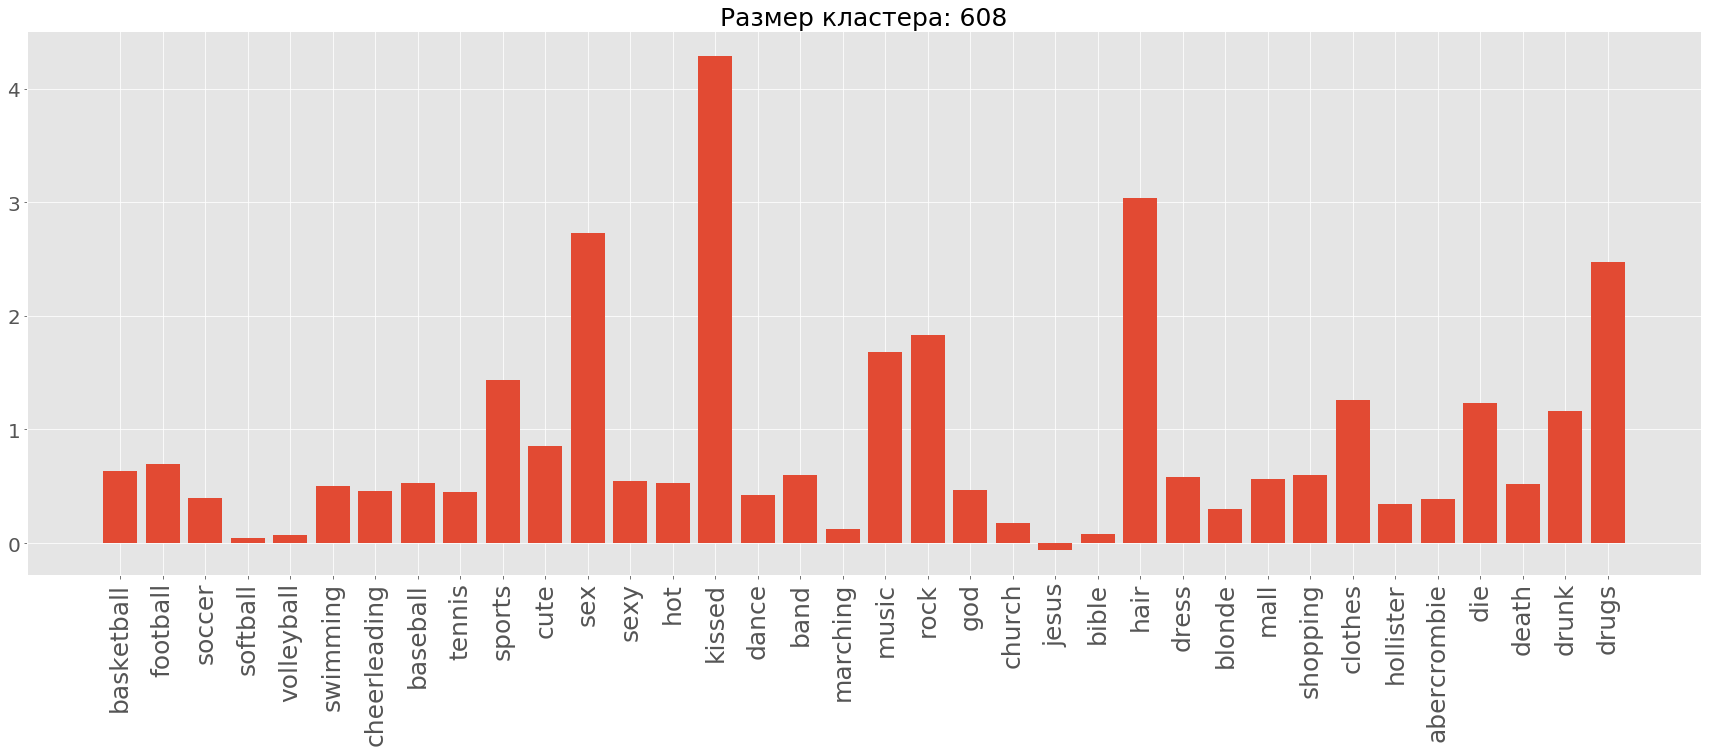

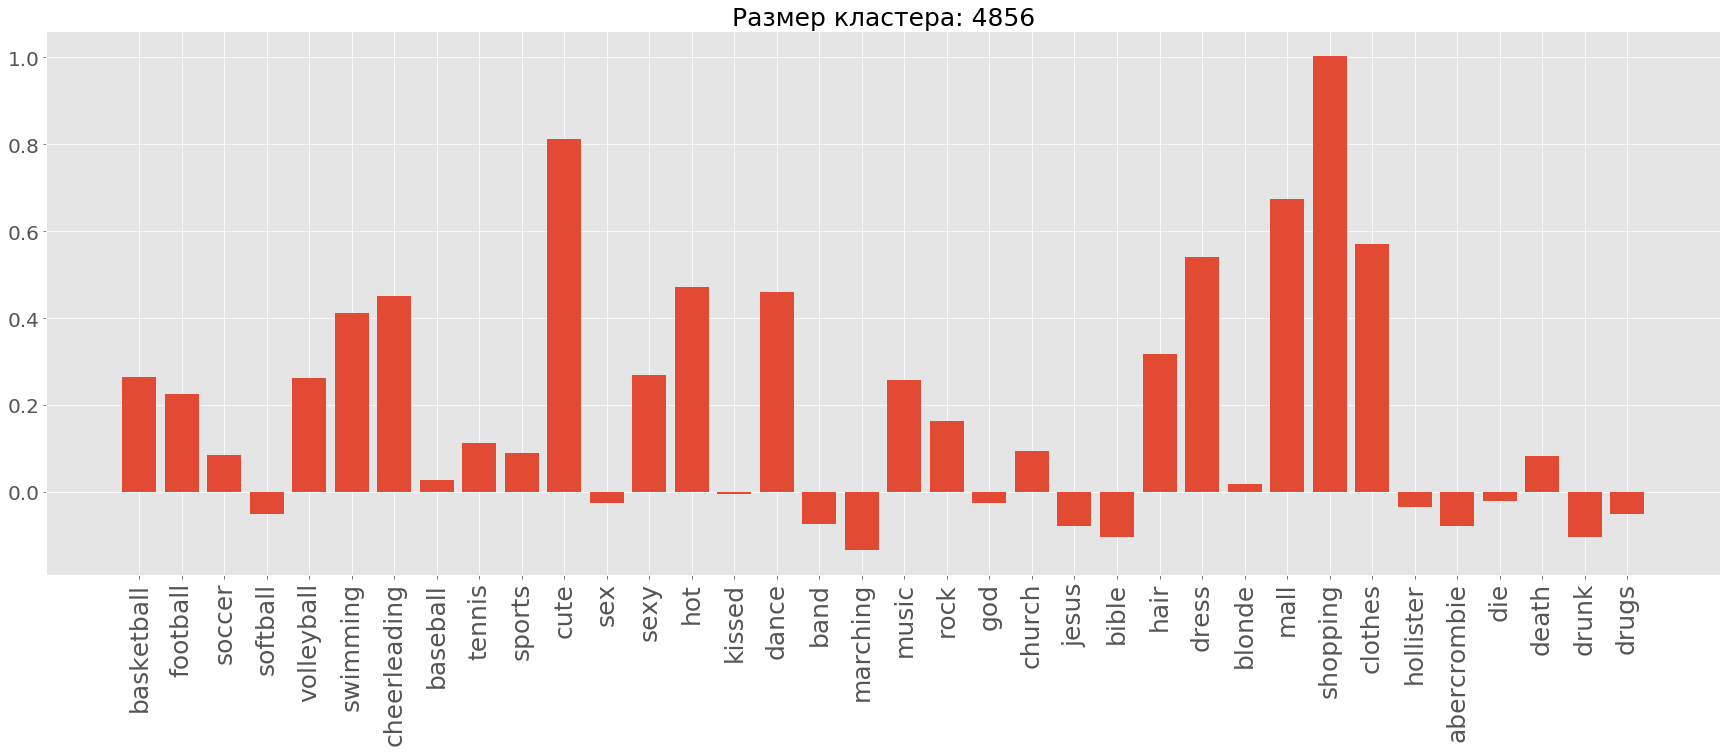

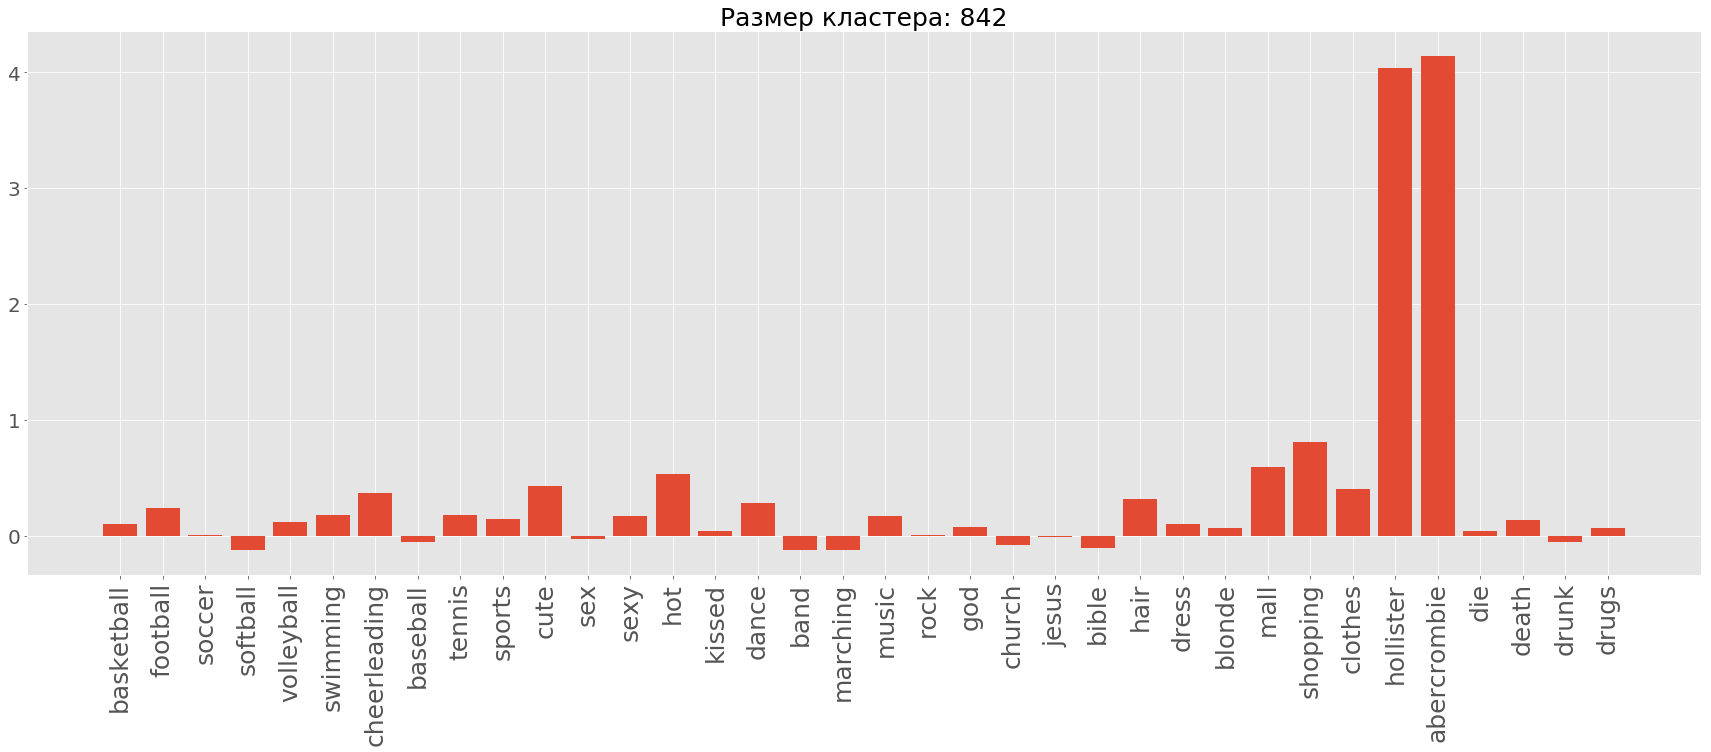

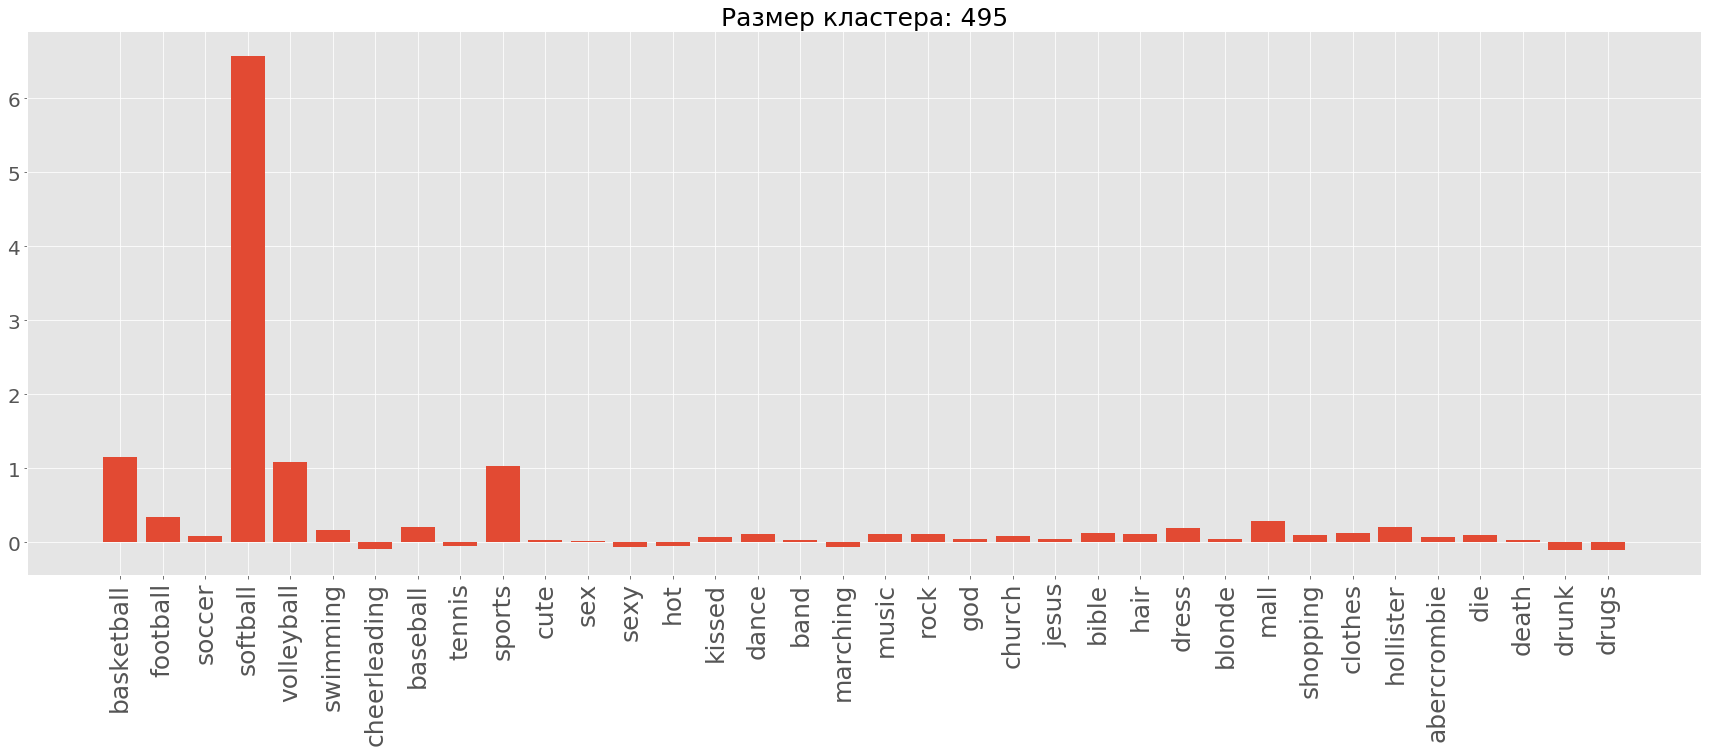

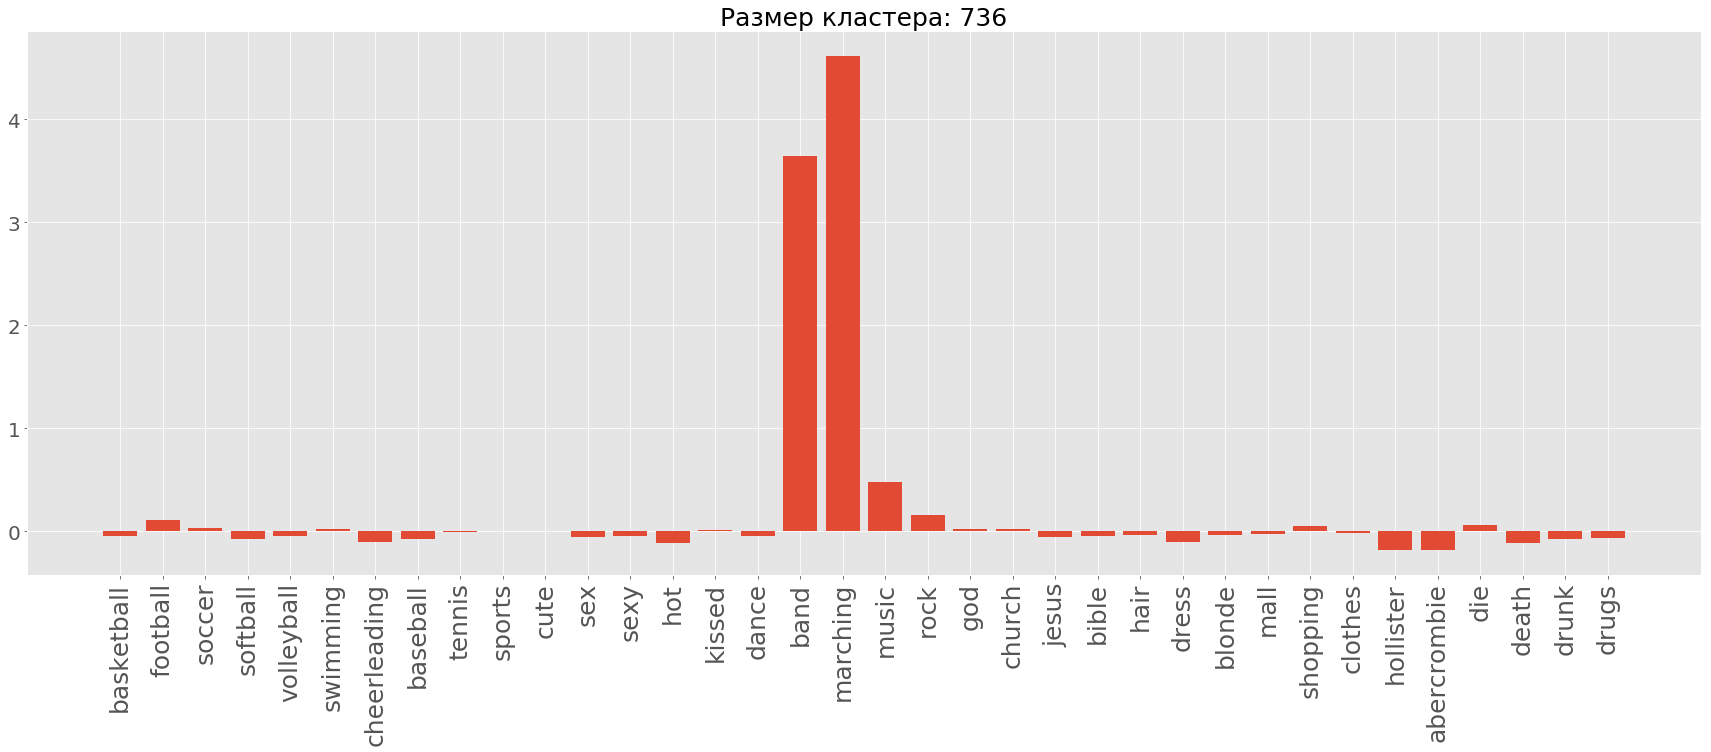

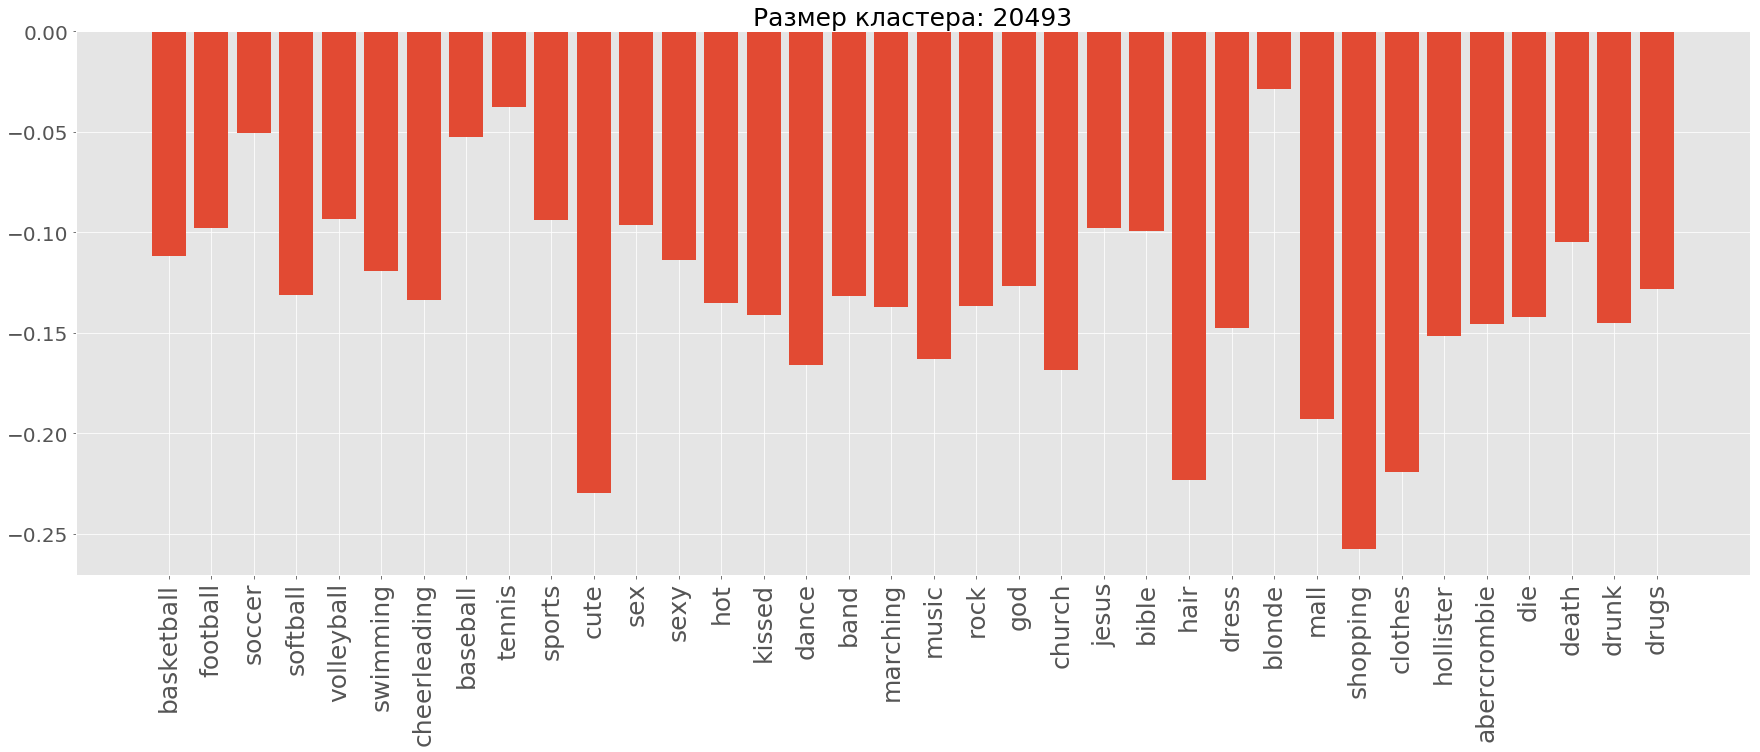

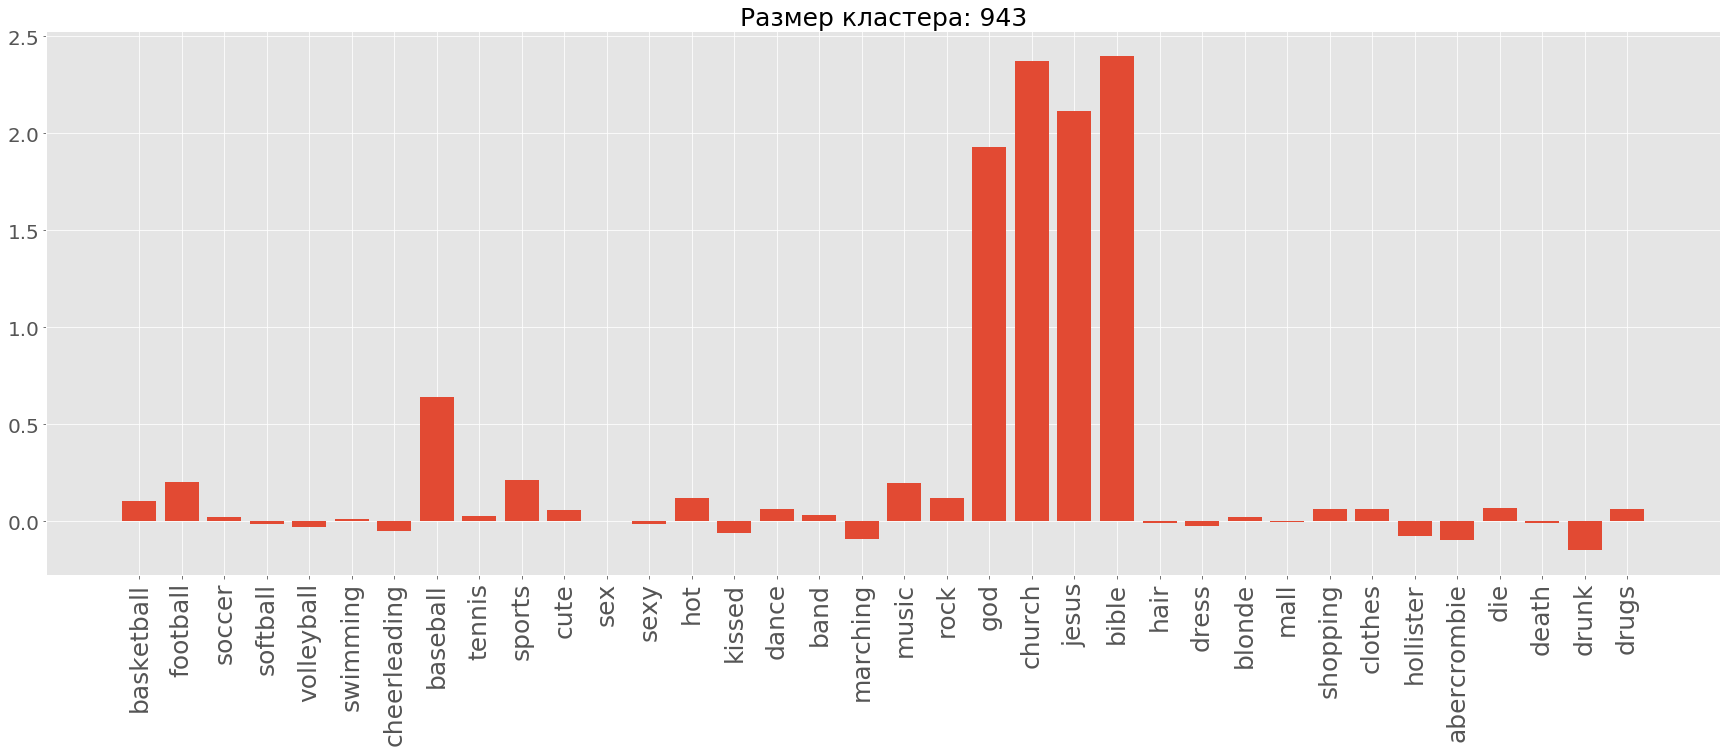

In [127]:
## MyKMeans++ с MiniBatchMyKMeans
mykmeans = MiniBatchKMeans(k=n_clusters, init='k-means', random_state=1234)
draw_plots(kmeans, df, n_clusters)
# графики практически совпадают с MiniBatchMyKMeans

In [ ]:
## Вывод
# Поскольку нет правильных значений, заранее известного y, то возможна только субъективная 
# оценка алгоритмов кластеризации. Применение MyKMeans++ сильно повлияло на формирование кластеров. 
# Использование MiniBatchKMeans практически не повлияло. Поэтому будем рассматривать две ветки алгоритмов: 
#     c MyKMeans++ инициализацией и Random инициализацией.

# Общими для этих алгоритмов оказались кластеры не проставивших интересы, верующих, любителей военной тематики, 

# Алгоритм с Random инициализацией выделил также любителей шопинга и любителей отдохнуть, 
#     но выделил их как две большие группы.
# Алгоритм с MyKMeans++ решил еще разбить эти группы на две подгруппы. В итоге получилось 4 маленьких кластера 
#     вместо двух, но зато более подробных. 

# MyKMeans++ также сумел выделить группу с мыслями о смерти, не нашел любителей тенниса, но нашел любителей 
# софтбола. Random инициализация нашла группу с милыми девушками и еще 2 группы любителей спорта. 

# В итоге получается что все кластеры возможны и логичны. Возможно различия устранятся, если увеличить
# количества кластеров. Тогда каждый алгоритм найдет все группы и результаты будут совпадать

# Также возможно лучшим можно назвать алгортм который бы разбил выборку на кластеры примерно одинакового размера.
# Тогда лучшим будет MyKMeans++, поскольку у него нет слишком маленьких кластеров, тогда как с Random есть
#     два таких кластера.